# 1. Read Dataset=====================

### Create the data

https://www.ibm.com/docs/en/db2-event-store/2.0.0?topic=notebooks-markdown-jupyter-cheatsheet

https://cs231n.github.io/convolutional-networks/
https://medium.com/apache-mxnet/multi-channel-convolutions-explained-with-ms-excel-9bbf8eb77108

__[Link to github](https://github.com/sunyue-xfel/Comparing-End-to-End-Machine-Learning-Methods-for-Spectra-Classification/blob/main/SpectralFingerprint_L2Beamtime-WeightModel-FNN-DiffBin-20210513.ipynb)__

In [1]:
!pip install py7zr

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import random
import torch
from torch import nn, optim
import math
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
from cycler import cycler
import matplotlib.style
import matplotlib as mpl
from mpl_toolkits import mplot3d 

from matplotlib.lines import Line2D
import seaborn as sns

nn.Module comes in handy while writing many DL model. For example when you are trying to code Maxout Network as defined in the paper [Maxout Networks] (https://arxiv.org/pdf/1302.4389.pdf 44).
https://github.com/pytorch/pytorch/commit/c7c8aaa7f040dd449dbc6aca9204b2f943aef477
https://discuss.pytorch.org/t/multiple-parallel-fully-connected-layers-type-torch-cuda-floattensor-but-found-type-torch-floattensor/37810
https://www.geeksforgeeks.org/single-neuron-neural-network-python/
https://rhettinger.wordpress.com/2011/05/26/super-considered-super/


In [3]:
%matplotlib notebook
import glob, os, os.path
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
import bisect
import scipy.sparse as sparse  #for baseline subtraction
from matplotlib import rc
# rc('mathtext', default='regular')
import h5py
# torch.set_printoptions(threshold=100000)
# plt.style.use('science')

In [4]:
energy = torch.randn(1,3,5)
print(energy,torch.max(energy, -1, keepdim=True)[0].expand_as(energy))
energy_new = torch.max(energy, -1, keepdim=True)[0].expand_as(energy)-energy
print(energy_new)


tensor([[[ 0.3860,  0.7033, -1.7042, -0.0080,  1.0685],
         [ 0.9956, -0.7355,  0.4410,  0.1402, -0.4224],
         [-0.3145, -0.7764,  1.1893,  1.0227,  0.5232]]]) tensor([[[1.0685, 1.0685, 1.0685, 1.0685, 1.0685],
         [0.9956, 0.9956, 0.9956, 0.9956, 0.9956],
         [1.1893, 1.1893, 1.1893, 1.1893, 1.1893]]])
tensor([[[0.6825, 0.3652, 2.7727, 1.0765, 0.0000],
         [0.0000, 1.7311, 0.5546, 0.8554, 1.4180],
         [1.5038, 1.9657, 0.0000, 0.1667, 0.6662]]])


In [5]:
# hfont = {'fontname':'Helvetica'}

In [6]:
import shutil  # unpacks in current path unless an additional path argument is provided
! curl --output Mg20Fe80O_ramp_xyfiles_1_349_azimuthal_integrated.7z https://zenodo.org/record/4424866/files/Mg20Fe80O_ramp_xyfiles_1_349_azimuthal_integrated.7z

import os

path="dataset_1"

if not os.path.isdir(path):
    print('The directory is not present. Creating a new one..')
    os.mkdir(path)
    print(path)
else:
    print('The directory is present.')
    print(path)
    
# %mkdir -p path

import py7zr
with py7zr.SevenZipFile("Mg20Fe80O_ramp_xyfiles_1_349_azimuthal_integrated.7z", 'r') as archive:
    archive.extractall(path)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6083k  100 6083k    0     0  2501k      0  0:00:02  0:00:02 --:--:-- 2501k
The directory is present.
dataset_1


In [7]:
'''Definitions'''

def gaussian(x, x0, r, a, b):
    y = b + a*np.exp(-(x-x0)**2/(2*r**2))
    return y

def PseudoVoigtFunction(WavNr, Pos, Amp, GammaL, FracL):
    SigmaG = GammaL / np.sqrt(2*np.log(2)) # Calculate the sigma parameter  for the Gaussian distribution from GammaL (coupled in Pseudo-Voigt)
    LorentzPart = Amp / np.pi * (GammaL / ((WavNr - Pos)**2 + GammaL**2)) # Lorentzian distribution
    GaussPart = Amp / (np.sqrt(2*np.pi) * SigmaG) * np.exp( -(WavNr - Pos)**2 / (2 * SigmaG**2)) # Gaussian distribution
    Fit = FracL * LorentzPart + (1 - FracL) * GaussPart # Linear combination of the two parts (or distributions)
    return Fit

#baseline subtraction based on Asymetric Least Square Smoothing
#https://zanran_storage.s3.amazonaws.com/www.science.uva.nl/ContentPages/443199618.pdf
def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = sparse.linalg.spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z


# Function which extracts the number of all XYfiles in the directory.    
run_no=0
def get_number_XYfiles(run_no):
    directory = os.listdir('dataset_1/')
    number_XYfiles = run_no
    for Dir in directory:
        number_XYfiles = number_XYfiles+1
    return(number_XYfiles)

In [8]:
# show the number of XYfiles found in the directory
total_XYfiles = get_number_XYfiles(run_no)
print(total_XYfiles)
total_XYfiles=350 #[Pt=1084, MgFeOB1_263]
print('The number of XYfiles within the chosen run is:', total_XYfiles)
%pwd
%mkdir -p ClassificationFigures
save_figures_to = 'ClassificationFigures/'

349
The number of XYfiles within the chosen run is: 350


In [9]:
save_figures_to

'ClassificationFigures/'

In [10]:
'''make sure that you have the right command directory selected'''
# %cd /gpfs/exfel/data/user/sunyue/Downloads/Brockhauser_Sandor/L2_Beamtime2019_Fe200culet_fe80mg20/XY/
%cd dataset_1
theta = [] 
I = []
baseline = []
Icorrect = []

test_y=total_XYfiles-2
for run_no in range(1,0+total_XYfiles):
    fileNO = str(run_no).zfill(4) 
    fname = 'l2_fe80mg20_ramp_00001_m1_'+str(run_no).zfill(4)+'.xy'
    thetas, Is = np.loadtxt(fname, skiprows=25, unpack=True) # reads all files in range and assigns 1st column to thetas and 2nd to Is
    I.append(Is) # attaches a new array each time to a copy of previous, not really necessary here
    idx1 = 0
    idx2 = 4050
#background subtraction
#parameters lam and p have to be adjusted by hand!
#try 10**2 < lam < 10**9
#    0.001 <  p  < 0.1
    lam = 100000
    p = 0.002
    baselines = baseline_als(Is[idx1:idx2], lam, p)
    baseline.append(baselines)
    Icorrected = Is[idx1:idx2] - baselines
    Icorrect.append(Icorrected)
#    if (run_no==15): 
#        print(thetas.size, Is.shape,type(I),np.shape(I),len(Icorrected),len(baselines),sep='\n')
    thetas = thetas[idx1:idx2]
    theta.append(thetas)

/gpfs/exfel/data/user/sunyue/Mybinder_test/dataset_1


In [11]:
print(theta[0].shape,np.size(theta),len(theta),np.size(theta[0]))

(4023,) 1404027 349 4023


In [12]:
349*4023

1404027

<IPython.core.display.Javascript object>


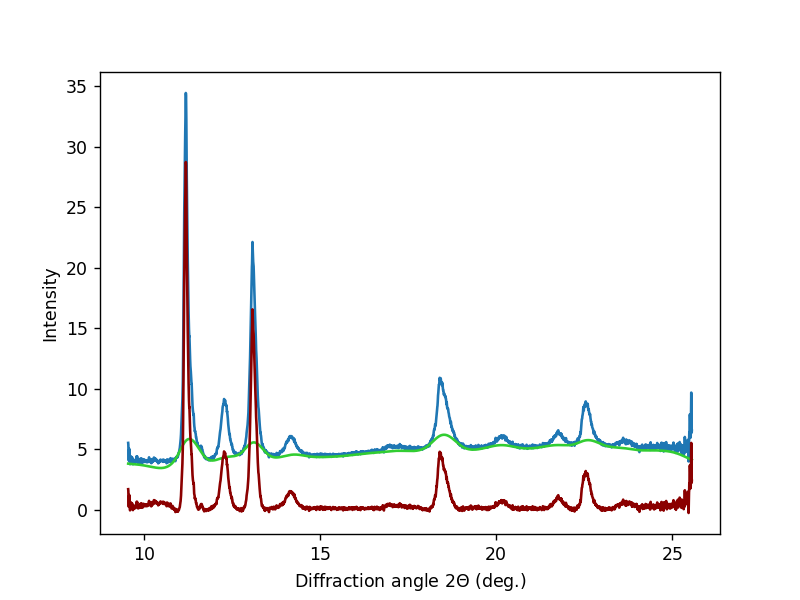

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

In [13]:
plt.figure()
plt.plot(theta[98], I[98][idx1:idx2])
plt.plot(theta[98], baseline[98],color = 'limegreen')
plt.plot(theta[98], Icorrect[98], color = 'darkred')
#plt.plot(theta[0], I[0], color = 'red')
#plt.plot(theta[1500], I[1500][idx1:idx2])
#plt.plot(theta[1500], baseline[1500])
#plt.plot(theta[450], Icorrect[450], color = 'limegreen')
#plt.plot(theta[420], I[420], color = 'limegreen')
plt.ylabel('Intensity') #, fontsize = 12
plt.xlabel('Diffraction angle 2$\Theta$ (deg.)' )#, fontsize = 12
plt.tight_layout

In [14]:
def minibatch_plot_data(X, y, ai1=-1,ai2=1,bi1=-1,bi2=1,d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
#     plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=2, cmap=plt.cm.rainbow)
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=2, cmap=plt.cm.rainbow)
#     plt.axis('square')
#     plt.axis(np.array((ai1, ai2, bi1, bi2)) * zoom)
#     if auto is True: plt.axis('equal')
    plt.axis('on') 
    
def minibatch_plot_model(mndinx1,mndinx2,mndiny1,mndiny2,X2, y2, model):
    model.cpu()
#     nx, ny = (200, 200)
#     x = np.linspace(mndinx1, mndinx2, nx)
#     y = np.linspace(mndiny1,mndiny2, ny)
    x = np.arange(mndinx1, mndinx2, 0.02)
    y = np.arange(mndiny1, mndiny2, 0.001)
    xx, yy = np.meshgrid(x, y)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
    minibatch_plot_data(X2, y2,mndinx1,mndinx2,mndiny1,mndiny2,zoom=1)

In [15]:
def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
#     plt.figure(figsize=(8,6))
    ax = plt.subplot(111)
    ax.set_ylabel('Intensity', )#fontsize = 16,
    ax.set_xlabel('Diffraction angle 2$\Theta$ (deg.)', )#fontsize = 16
#     plt.axis(np.array((axl, axr, byl, byh)) * zoom)
    
    plt.rc('xtick') #,labelsize=16
    plt.rc('ytick') #,labelsize=16
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=0.4, cmap=plt.cm.rainbow)

In [16]:
def set_default(figsize=(8,6)):
#     plt.style.use(['dark_background', 'bmh'])
#     plt.rc('figure', facecolor='none')
    plt.rc('figure', figsize=figsize)
    
def yue_plot_data(X, y, axl,axr,byl,byh,d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
#     plt.figure(figsize=(8,6))
    ax = plt.subplot(111)
    ax.set_ylabel('Intensity') # fontsize = 16,
    ax.set_xlabel('Diffraction angle 2$\Theta$ (deg.)')#, fontsize = 16
    plt.axis(np.array((axl, axr, byl, byh)) * zoom)
    
    plt.rc('xtick') #,labelsize=16
    plt.rc('ytick') #,labelsize=16
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=0.6, cmap=plt.cm.rainbow)


def ys_plot_model(X, y, model):
    plt.figure(figsize=(8,6))
    bx = plt.subplot(111)
#     bx.set_ylabel('Intensity', )#fontsize = 16,
#     bx.set_xlabel('Diffraction angle 2$\Theta$ (deg.)', )#fontsize = 16
    plt.axis([axl, axr, byl, byh])
    
    
    model.cpu()
    X=X.cpu()
    mesh1 = np.arange(axl, axr, 0.01)
    mesh2 = np.arange(byl, byh, 0.01)
    xx, yy = np.meshgrid(mesh1, mesh2)
    
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float().cpu()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)     
    yue_plot_data(X, y, axl,axr,byl,byh)
    
def yue_plot_3D(X, X_axis):
    X = X.cpu()
    X_axis = X_axis.cpu()    
    
    fig = plt.figure(figsize = (10, 7)) 
    ax = plt.axes(projection ="3d") 

    # Creating plot 
    ax.scatter3D(X_axis.numpy(), X.numpy()[:, 0], X.numpy()[:, 1],s=0.3, color = "green"); 
    
    plt.title("Spectra 3D scatter plot") 
    ax.set_xlabel('X-axis', fontweight ='bold')  
    ax.set_ylabel('angle', fontweight ='bold')  
    ax.set_zlabel('intensity', fontweight ='bold') 

    # show plot 
    plt.show() 

In [17]:
set_default()

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 2. Select Representative spectra for Training & Testing ===========

###  representative spectral curves for training

In [19]:
%cd -

/gpfs/exfel/data/user/sunyue/Mybinder_test


<IPython.core.display.Javascript object>


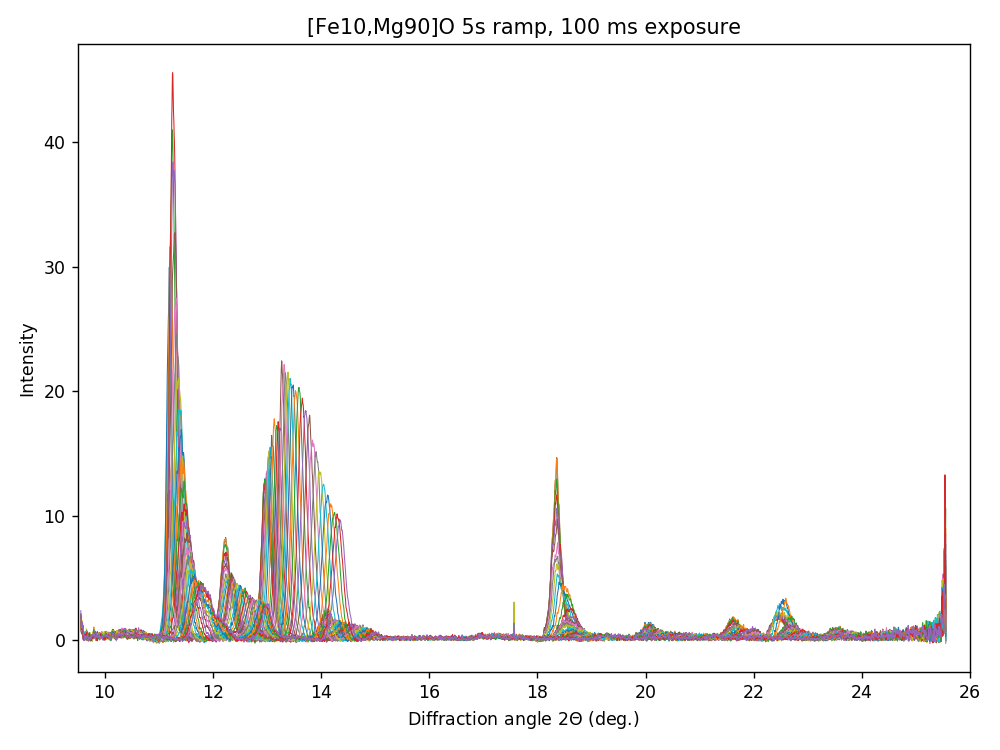

(4023,) 35 19


In [20]:

# data for training
#plotting various plots to show development of bcc -> hcp transition
plt.figure()#figsize=(8,8)

plt.rc('xtick') #,labelsize=16
plt.rc('ytick') #,labelsize=16

# These are the colors that will be used in the plot
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']

ax = plt.subplot(111)
N=len(theta[0])

X_1 = []# training: theta
X_2 = []# training: intensity
y   = []
global Ci,Ci_0,div_num,gap #indicates num of curves, and curves of class0.
div_num = 185 #indicates the boundary of spectral curves.
gap = 10
Ci = 0  
Ci_0 = 0
X_axis=[] # used to store data for 3D plotting

for pct in range(0,total_XYfiles-1,gap):
    #ax.plot(theta[pct], Icorrect[pct]+6-pct/50., color = 'limegreen' if pct <200 else 'blue')
    #ax.plot(theta[pct], Icorrect[pct]+6-pct/50., color = color_sequence[Ci])
#     ax.plot(theta[pct], Icorrect[pct]+6-pct/50.,lw=1)
    ax.plot(theta[pct], Icorrect[pct],lw=0.6)
 
    #testX = torch.FloatTensor(theta[pct])
    #testX = torch.cat((testX),1)
    
    Icorrect_t = Icorrect[pct]
#     Icorrect_t = Icorrect[pct]+6-pct/50.
    theta_t = theta[pct]
    X_1.append(theta_t)
    X_2.append(Icorrect_t)
    X_axis.append(np.ones(N)*pct) 
    
    Ci += 1
    if pct <div_num:
        Ci_0 += 1
    #y.append(torch.zeros(1,size(theta[pct])) if pct < 200 else torch.ones(1,size(theta[pct]))

             
print(X_1[0].shape,Ci,Ci_0)


ax.set_ylabel('Intensity')
ax.set_xlabel('Diffraction angle 2$\Theta$ (deg.)')
# ax.set_ylim(-2,45)
ax.set_xlim(9.5,26)

plt.title('[Fe10,Mg90]O 5s ramp, 100 ms exposure') #, fontweight='bold'

# ax.spines['right'].set_visible(False) #remove right axis spine
# ax.spines['top'].set_visible(False) # remove top axis spine
plt.tight_layout()
plt.savefig(save_figures_to+"Original data used for training.png", bbox_inches='tight', dpi=300)

<IPython.core.display.Javascript object>


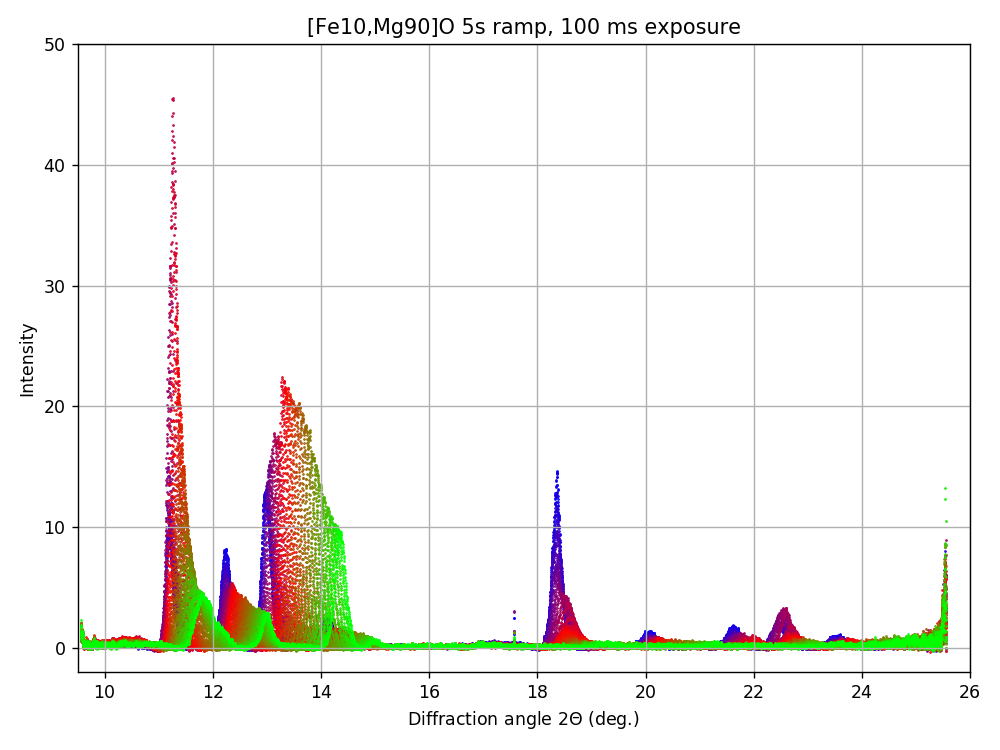

In [21]:
#plotting spectra in another way
plt.figure() #figsize=(8,8)
plt.rc('xtick') #,labelsize=16
plt.rc('ytick') #,labelsize=16

ax = plt.subplot(111)
t_gap = gap # this parameter decide the number of spectral curves for test.

import matplotlib.cm as cm
colors = cm.brg(np.linspace(0, 1, len(range(0,total_XYfiles-1,t_gap)))) # or gist_rainbow

pos_d=0
for pct,cc in zip(range(0,total_XYfiles-1,t_gap),colors):
    pct = pct+pos_d
    plt.scatter(theta[pct], Icorrect[pct], color=cc,s=0.3)
    
ax.set_ylabel('Intensity') #, fontsize = 16,
ax.set_xlabel('Diffraction angle 2$\Theta$ (deg.)')#, fontsize = 16
ax.set_ylim(-2,50)
ax.set_xlim(9.5,26)
plt.grid(True)
plt.title('[Fe10,Mg90]O 5s ramp, 100 ms exposure') #, fontsize=16, fontweight='bold'
plt.tight_layout()
plt.savefig(save_figures_to+"Spectra data for testing (manually classified).png", bbox_inches='tight', dpi=300)



torch.Size([35, 4023])
torch.Size([140805, 1])


<IPython.core.display.Javascript object>


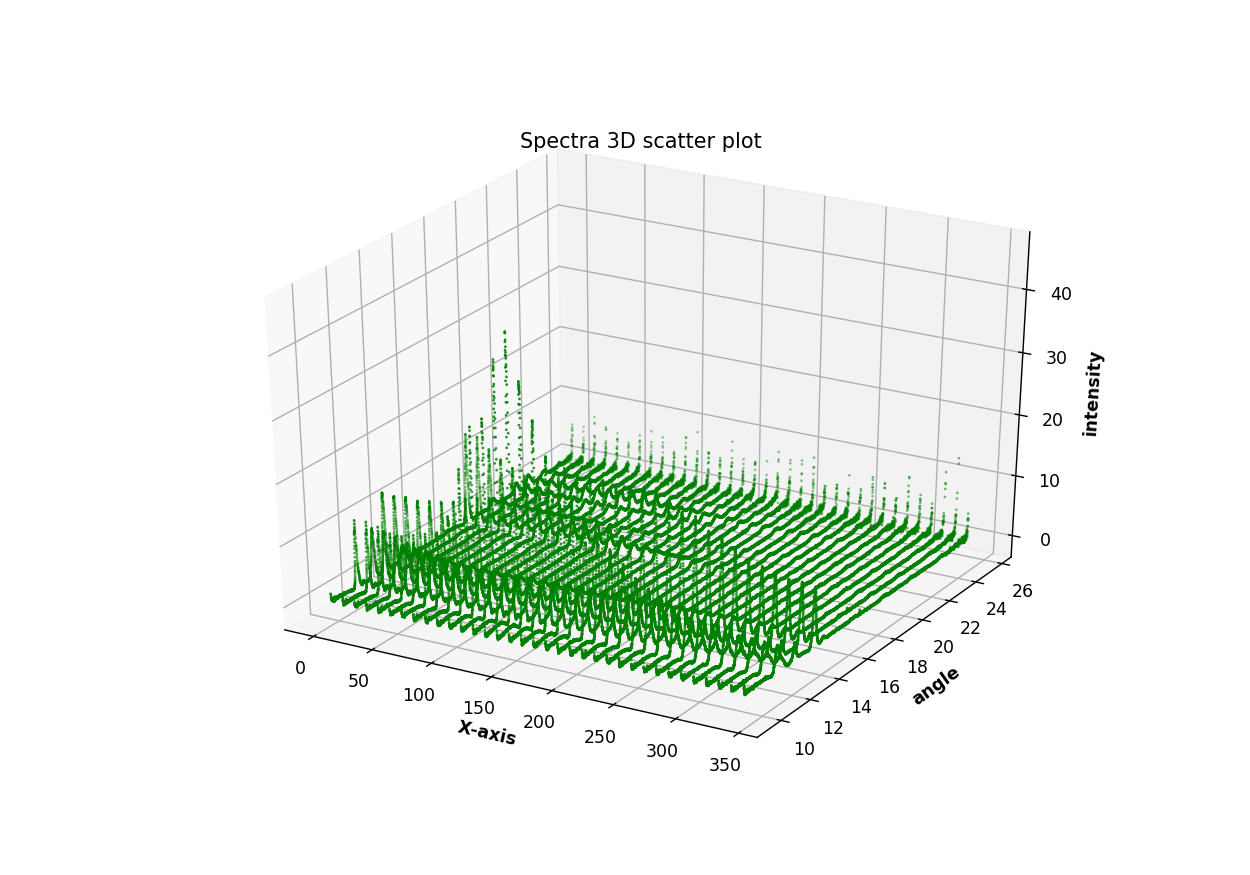

<IPython.core.display.Javascript object>


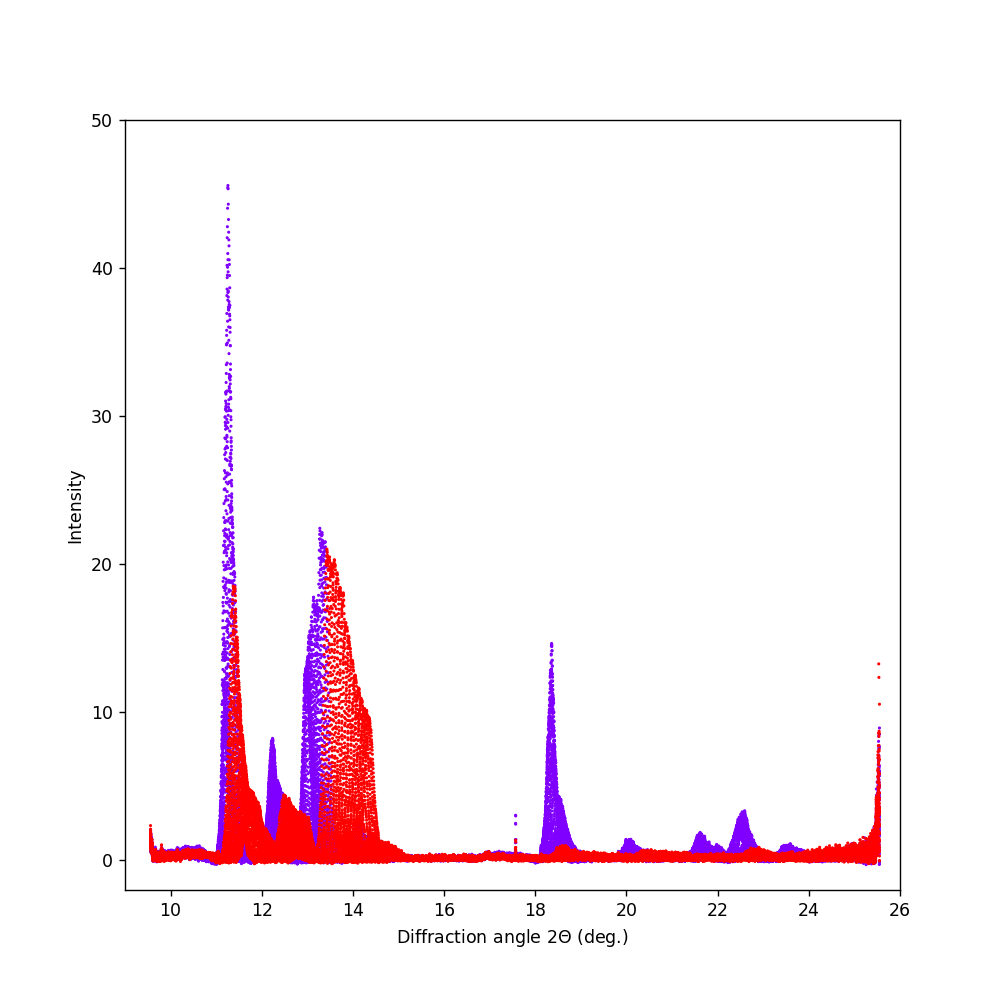

In [22]:
# data for training

global axl,axr,byl,byh,Ci
X_1=torch.FloatTensor(X_1)
X_2=torch.FloatTensor(X_2)
print(X_1.shape)
X_1=torch.reshape(X_1,(-1,1))
X_2=torch.reshape(X_2,(-1,1))
print(X_1.shape)
X_TR=torch.cat((X_1,X_2),1).to(device)

y_1 = torch.zeros(Ci_0 * (theta[0].size), dtype=torch.long)
y_2 = torch.ones((Ci-Ci_0)* (theta[0].size), dtype=torch.long)
Y_TR   = torch.cat((y_1,y_2),0).to(device)
# print(X_1.shape,X_2.shape,X.shape,y.shape,y,X_1,X_2,sep='\n')

# plot 3D spectra data
X_axis=torch.FloatTensor(X_axis)
X_axis=torch.reshape(X_axis,(-1,1))
yue_plot_3D(X_TR,X_axis)


axl=9
axr=26
byl=-2
byh=50

plt.figure(figsize=(8,8))
yue_plot_data(X_TR, Y_TR, axl,axr,byl,byh)
plt.savefig(save_figures_to+"Original data used for training(manually classified).png", bbox_inches='tight', dpi=300)


# X = X.cpu()
# y = y.cpu()
# plt.figure()
# plt.scatter(X.numpy()[:, 1], X.numpy()[:, 0], s=0.2)
# plt.show()


In [23]:
X_2.shape

torch.Size([140805, 1])

## data for training

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
torch.Size([35, 4023])
torch.Size([0, 4023]) torch.Size([4023])
torch.Size([1, 4023]) torch.Size([4023])
torch.Size([2, 4023]) torch.Size([4023])
torch.Size([3, 4023]) torch.Size([4023])
torch.Size([4, 4023]) torch.Size([4023])
torch.Size([5, 4023]) torch.Size([4023])
torch.Size([6, 4023]) torch.Size([4023])
torch.Size([7, 4023]) torch.Size([4023])
torch.Size([8, 4023]) torch.Size([4023])
torch.Size([9, 4023]) torch.Size([4023])
torch.Size([10, 4023]) torch.Size([4023])
torch.Size([11, 4023]) torch.Size([4023])
torch.Size([12, 4023]) torch.Size([4023])
torch.Size([13, 4023]) torch.Size([4023])
torch.Size([14, 4023]) torch.Size([4023])
torch.Size([15, 4023]) torch.Size([4023])
torch.Size([16, 4023]) torch.Size([4023])
torch.Size([17, 4023]) torch.Size([4023])
torch.Size([18, 4023]) torch.Size([4023])
torch.Size([19, 4023]) torch.Size([4023])
torch.Size([20, 4023]) torch.Siz

<IPython.core.display.Javascript object>


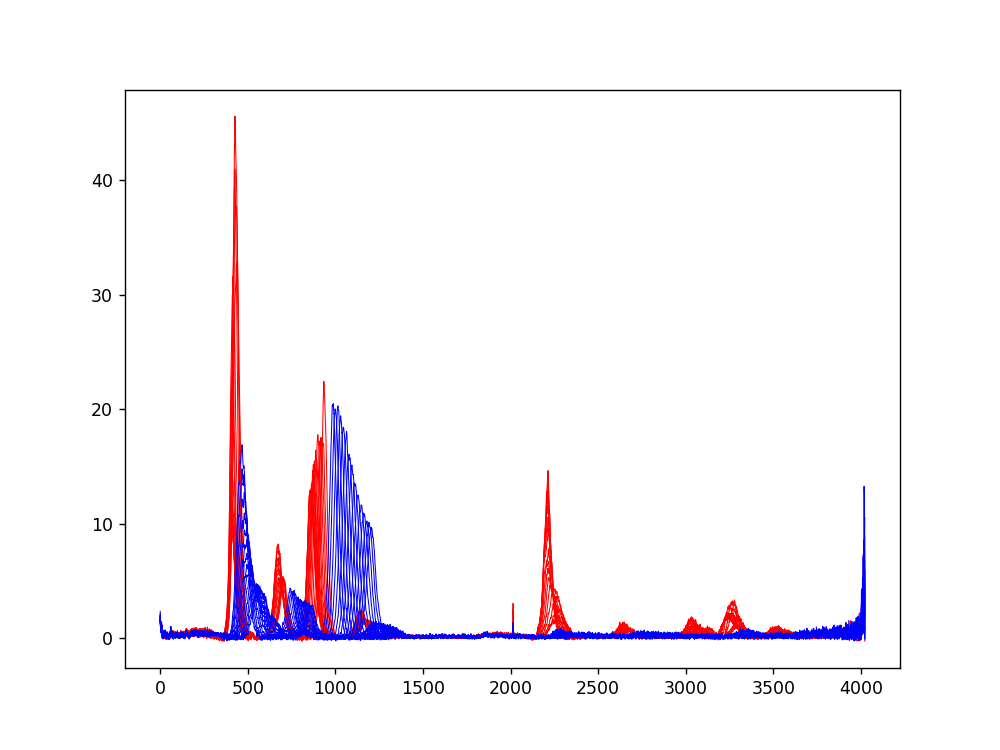

torch.Size([1581, 4023])
torch.Size([1581, 4023]) torch.Size([1581, 1]) <class 'torch.Tensor'>


In [24]:
p_num_c0=[i for i in range(16)] #[0,2,4,5,7,8,10,15] #1 #5  class 0 class 1 class 0
p_num_c1=[i for i in np.arange(20,35)] #[22,24,28,30,32,34] #1 #5  class 0 class 1 class 0

# p_num_c0=[i for i in range(8)] #[0,2,4,5,7,8,10,15] #1 #5  class 0 class 1 class 0
# p_num_c1=[i for i in np.arange(11,17)] #[22,24,28,30,32,34] #1 #5  class 0 class 1 class 0
p_num = p_num_c0 + p_num_c1
print(p_num)
N_TrainOrg = len(p_num)
Train_Gap = gap
X_2 = torch.reshape(X_2, (-1, N))
print(X_2.shape)
Xtemp = torch.zeros(len(p_num),N)
Xtemp_s = torch.zeros(len(p_num),N)
X_Extrem_tmp = torch.empty(0,N)
for i in range(len(p_num)):
    Xtemp[i] = X_2[p_num[i]] # intensity
    print(X_Extrem_tmp.shape,Xtemp[i].shape)
    X_Extrem_tmp=torch.cat((X_Extrem_tmp,torch.reshape(Xtemp[i],(1,-1))),0)
print(Xtemp.shape)

X_Extrem= torch.empty(0,N)
X_Extrem    =torch.cat((X_Extrem,X_Extrem_tmp),0) #  spectral curve are stacked in one column.

plt.figure(figsize=(8,6))
ax = plt.subplot(111)
for n in range(len(p_num)):
    ax.plot(Xtemp[n],lw=0.6,color='red'if (p_num[n]*Train_Gap < 160) else 'blue')
N_sim = 50 # number of simulated spectra for each original ones

# plt.figure(figsize=(8,6))
ax = plt.subplot(111)
for n in range(N_sim):
    X_Extrem_tmp = torch.empty(0,N)
    seed = n*1000
    random.seed(seed)
    torch.manual_seed(seed)
    for j in range(len(p_num)):
        for i in range(N):
            Xtemp_s[j,i] = Xtemp[j,i] +random.random()/6
#         ax.plot(Xtemp_s[j],lw=0.6,color='red' if j< len(p_num_c0) else 'blue')
        X_Extrem_tmp=torch.cat((X_Extrem_tmp,torch.reshape(Xtemp_s[j],(1,-1))),0)
    X_Extrem    =torch.cat((X_Extrem,X_Extrem_tmp),0) #  spectral curve are stacked in one column.
#     y_Extrem_tmp=torch.cat((ytemp1,ytemp2),0)
#     y_Extrem    =torch.cat((y_Extrem,y_Extrem_tmp),0)
# one row for one spectral curve:
print((X_Extrem).shape)

# plt.tight_layout()


N_Train=N_TrainOrg*N_sim+N_TrainOrg


#  ===============================method 2============================
global X2,y2  
X2 = X_Extrem.to(device)
y2_orig = torch.cat((torch.zeros(len(p_num_c0),1),torch.ones(len(p_num_c1),1)),0)
y2 = torch.empty(0)
for n in range((N_sim+1)):
    y2= torch.cat([y2, y2_orig], dim=0) 

y2 = torch.reshape(y2,(-1,1)).to(device)
print(X2.shape,y2.shape,type(y2))

## data for testing

<IPython.core.display.Javascript object>


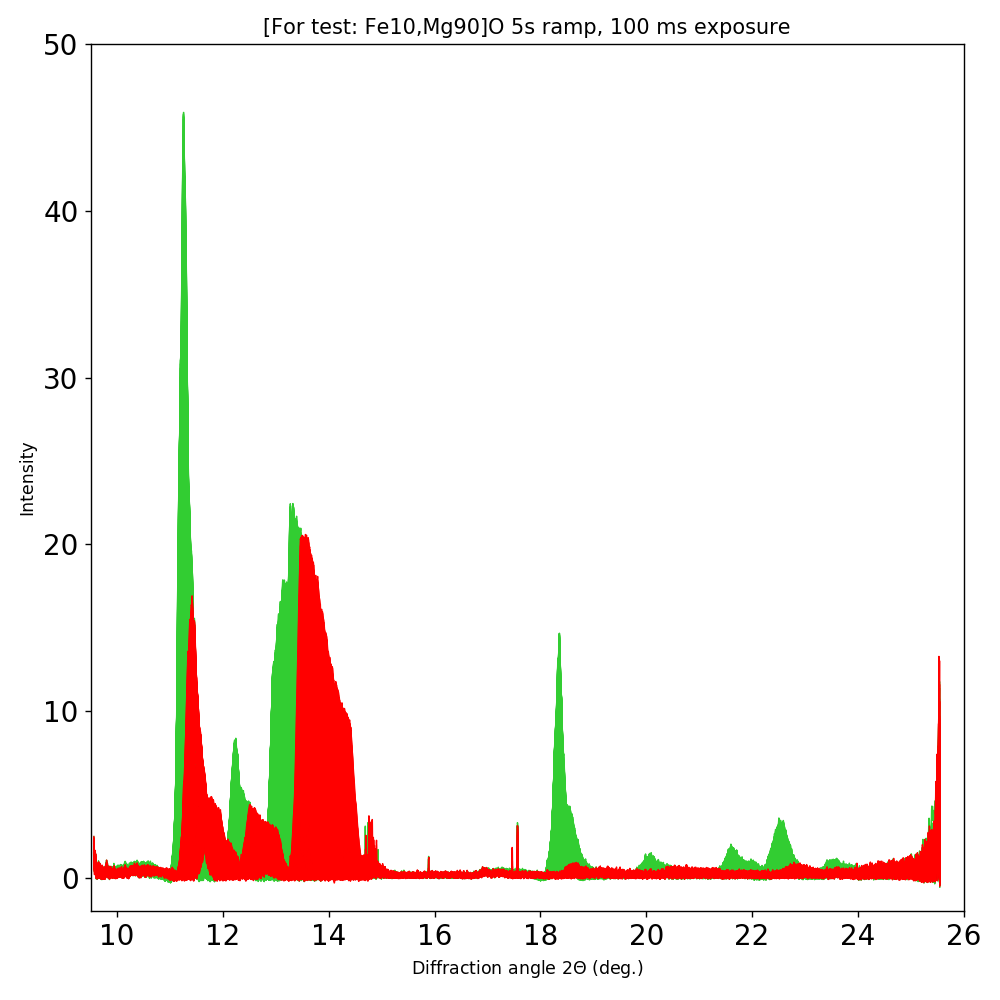

0 [] 349 <class 'list'> <class 'list'>
349 185


In [25]:
## plotting various plots to show development of bcc -> hcp transition
plt.figure(figsize=(8,8))

plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

# These are the colors that will be used in the plot
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']

ax = plt.subplot(111)

Xt_1 = []# theta for test
Xt_2 = []# intensity for test
yt   = []
global Ntn,Ntn_0 #indicates num of test curves, and curves of class0.
Ntn = 0  # num of test curves,
Ntn_0 = 0 #and num of curves of class0
pos_d=0
t_gap=1
for pct in range(0,total_XYfiles-1,t_gap):
    pct = pct+pos_d
    ax.plot(theta[pct], Icorrect[pct], color = 'limegreen' if pct <200 else 'red',lw=0.8)
#     ax.plot(theta[pct], Icorrect[pct],lw=0.8)
    #ax.plot(theta[pct], Icorrect[pct]+6-pct/50., color = color_sequence[Ci])
    #ax.plot(theta[pct], Icorrect[pct]+6-pct/50.)
    Ntn += 1
    if pct <div_num:
        Ntn_0 += 1
#         yt.append(np.zeros(theta[0].size)) # tensor type
#     else:
#         yt.append(np.ones(theta[0].size))
    

    Icorrect_t = Icorrect[pct]
    theta_t = theta[pct]
    Xt_1.append(theta_t)
    Xt_2.append(Icorrect_t)
    #y.append(torch.zeros(1,size(theta[pct])) if pct < 200 else torch.ones(1,size(theta[pct]))

print(len(yt),yt,len(Xt_1),type(Xt_1),type(yt))            


ax.set_ylabel('Intensity')# , fontsize = 16,
ax.set_xlabel('Diffraction angle 2$\Theta$ (deg.)')# , fontsize = 16
ax.set_ylim(-2,50)
ax.set_xlim(9.5,26)

plt.title('[For test: Fe10,Mg90]O 5s ramp, 100 ms exposure') #, fontsize=16, fontweight='bold'
plt.tight_layout()
plt.savefig(save_figures_to+"Spectra data for testing (manually classified).png", bbox_inches='tight', dpi=300)

# ax.spines['right'].set_visible(False) #remove right axis spine
# ax.spines['top'].set_visible(False) # remove top axis spine

print(Ntn,Ntn_0)

In [26]:
print(type(theta_t))

<class 'numpy.ndarray'>


# testing input and example

<class 'list'>


<IPython.core.display.Javascript object>


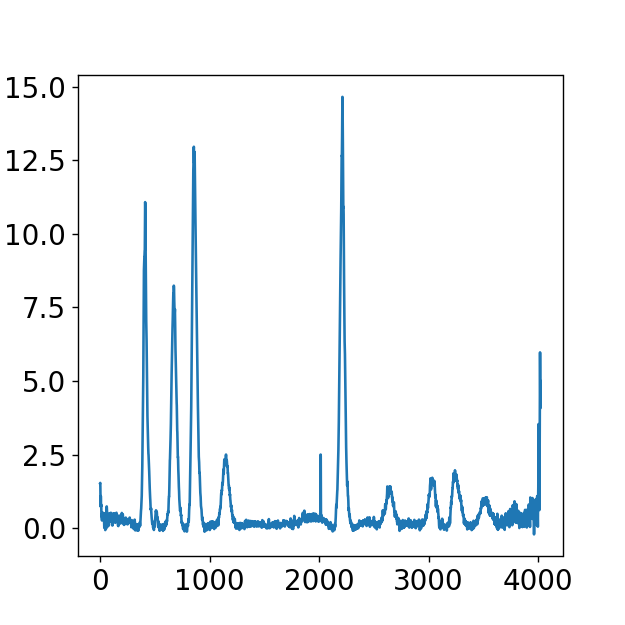

torch.Size([349, 4023]) <class 'torch.Tensor'> <class 'list'>


In [27]:
# data for testing
global Xt,yt
print(type(Xt_1))
Xt_1=torch.FloatTensor(Xt_1) # convert list type to tensor
Xt_2=torch.FloatTensor(Xt_2) # convert list type to tensor
Xt_1=torch.reshape(Xt_1,(-1,N))
Xt_2=torch.reshape(Xt_2,(-1,N))

Xt_1plt=torch.reshape(Xt_1,(-1,1))
Xt_2plt=torch.reshape(Xt_2,(-1,1))
Xt=torch.cat((Xt_1plt,Xt_2plt),1).to(device)

X2t=Xt_2.to(device) # only use intensity information
plt.figure(figsize=(5,5))
plt.plot(Xt_2[0,:])

# yt_1 = torch.zeros(Ntn_0 * (theta[0].size), dtype=torch.long)
# yt_2 = torch.ones((Ntn-Ntn_0)* (theta[0].size), dtype=torch.long)
# yt   = torch.cat((yt_1,yt_2),0).to(device)
# print(Xt_1.shape,Xt_2.shape,Ntn,Ntn_0,Xt.shape,yt.shape,yt,Xt_1,Xt_2,sep='\n')
print(X2t.shape,type(Xt_1),type(yt))



# yue_plot_data(Xt, yt, axl,axr,byl,byh)

# 3. Bulid Model and Training process==========

In [28]:
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
N = np.size(theta[0])  # num_samples_per_class
D = 2  # dimensions
C = 2  # num_classes
H = 50 # num_hidden_units
B = 33 # num_bins
S = 0 #bin id
# Ntn= 2 # num_test_classes
Si=0
iternum = 5
n_feature =20

global N2 
global N_Train

N2=int(N/B)

model_path = os.getcwd() +'/ModelPath/'


if not os.path.isdir(model_path):
    print('The directory is not present. Creating a new one..')
    os.mkdir(model_path)
    print(model_path)
else:
    print('The directory is present.')

The directory is present.


In [29]:
print(model_path)

/gpfs/exfel/data/user/sunyue/Mybinder_test/ModelPath/


nn.Conv1d() applies 1D convolution over the input. nn.Conv1d() expects the input to be of the shape [batch_size, input_channels, signal_length] .
Conv1d — Input 2d
To apply 1D convolution on a 2d input signal, we can do the following. First, we define our input tensor of the size [1, 2, 5] where batch_size = 1, input_channels = 2 , and signal_length = 5 .


You are forgetting the "minibatch dimension", each "1D" sample has indeed two dimensions: the number of channels (7 in your example) and length (10 in your case). However, pytorch expects as input not a single sample, but rather a minibatch of B samples stacked together along the "minibatch dimension".
So a "1D" CNN in pytorch expects a 3D tensor as input: BxCxT. If you only have one signal, you can add a singleton dimension:

 out = model(torch.tensor(X)[None, ...])

https://github.com/junfu1115/DANet/blob/56a612ec1ed5c2573ebc8df04ad08475fbf13a52/encoding/nn/da_att.py#L19

## Channel Attention module (CAM)

In [30]:
###########################################################################
# Created by: CASIA IVA
# Email: jliu@nlpr.ia.ac.cn
# Copyright (c) 2018
###########################################################################

import numpy as np
import torch
import math
from torch.nn import Module, Sequential, Conv1d, ReLU,AdaptiveMaxPool1d, AdaptiveAvgPool1d, \
    NLLLoss, BCELoss, CrossEntropyLoss, AvgPool1d, MaxPool1d, Parameter, Linear, Sigmoid, Softmax, Dropout, Embedding
from torch.nn import functional as F
from torch.autograd import Variable
torch_ver = torch.__version__[:3]

__all__ = ['PAM_Module', 'CAM_Module']


class CAM_Module(Module):
    """ Channel attention module"""
    def __init__(self):
        super(CAM_Module, self).__init__()
#         self.chanel_in = in_dim


        self.gamma = Parameter(torch.zeros(1))
        self.softmax  = Softmax(dim=-1)
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X N)
            returns :
                out : attention value + input feature
                attention: B X C X C
        """
        m_batchsize, C, N= x.size()
        proj_query = x
        proj_key = x.permute(0, 2, 1)
#         energy = torch.bmm(proj_query, proj_key)
#         energy_new = torch.max(energy, -1, keepdim=True)[0].expand_as(energy)-energy
#         energy_new = energy-torch.max(energy, -1, keepdim=True)[0].expand_as(energy)
        energy = torch.bmm(proj_query, proj_key)/math.sqrt(N)
        energy_new = energy
        attention = self.softmax(energy_new)
        proj_value = x

        out = torch.bmm(attention, proj_value)
#         out = out.view(m_batchsize, C, height, width)

        out = self.gamma*out + x
        return out, attention


## Postion encoding

In [31]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


# Temporarily leave PositionalEncoding module here. Will be moved somewhere else.
class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens
        in the sequence. The positional encodings have the same dimension as
        the embeddings, so that the two can be summed. Here, we use sine and cosine
        functions of different frequencies.
    .. math::
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)




# Model with spatial, channel, and temporal attention (ConvSCT Attention)

In [32]:
# Model with channel attention and conv again (ConvSC Attention Model)import math
import torch
import torch.nn as nn
import torch.nn.functional as F

  

class MultiBinSegm(nn.Module):
    def __init__(self, n_feature=64,  O_channel=8, O_feature=1,output_dim = 1, dim_feedforward =1024, hidden_size = 150,dropout=0.0, BinNum = B,embed_dim =256, num_heads_S = 4,num_heads_C = 2, num_heads_T =2):
        super(MultiBinSegm,self).__init__()
        self.BinNum = BinNum
        # weighted attention fusing
#         self.alpha1 = Parameter(torch.zeros(1))
#         self.alpha2 = Parameter(torch.zeros(1))
        
        self.conv1 = nn.Sequential(nn.Conv1d(1, n_feature, kernel_size=5,stride=2),
                                   nn.BatchNorm1d(n_feature),
                                   nn.ReLU(),
                                   nn.MaxPool1d(2)
                                   )
        
        
#         self.conv2 = nn.Sequential(nn.Conv1d(n_feature, n_feature, kernel_size=3,stride=2),
#                                    nn.ReLU(),
#                                    nn.MaxPool1d(2)
#                                    )
        self.conv3 = nn.Sequential(nn.Conv1d(n_feature, O_channel, kernel_size=5),
                                   nn.BatchNorm1d(O_channel),
                                   nn.ReLU(),
                                   nn.MaxPool1d(2)
                                   )
    
        self.dec_conv3 = nn.Sequential(nn.Conv1d(O_channel, 1, kernel_size=1),
                                   nn.BatchNorm1d(1),
                                   nn.ReLU(),
#                                    nn.MaxPool1d(2)
                                   )
        self.dec_conv3_T = nn.Sequential(nn.Conv1d(1, 1, kernel_size=1),
                                   nn.BatchNorm1d(1),
                                   nn.ReLU(),
#                                    nn.MaxPool1d(2)
                                   )
        input_shape_emb = (1, 1, N) # just for test, in order to get the shape of FNN input neurons            
        self.output_dimension_emb = self._get_conv_output_emb(input_shape_emb)
        
        input_shape_fc = (1, O_channel, embed_dim) 
        self.output_dimension_fc = self._get_conv_output_fc(input_shape_fc)
        
        
        self.embeding = nn.Sequential( 
            nn.Linear(self.output_dimension_emb, embed_dim),
            nn.LayerNorm(embed_dim),
#             nn.ReLU(),
        )
                                      
        self.MultiHeadAttention_S = nn.MultiheadAttention(O_channel, num_heads_S).to(device)
        self.MultiHeadAttention_C = CAM_Module().to(device)
#         self.C_Attention_F = CAM_Module().to(device)
        
        self.LayerNorm = nn.LayerNorm(embed_dim)
        self.fc1 = nn.Sequential(
            nn.Linear(self.output_dimension_fc*1, O_feature),
            nn.Sigmoid()
        )
            
#         self.fc1 = nn.Sequential(
#             nn.Linear(self.output_dimension, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, O_feature),            
#             nn.Sigmoid()
# #             nn.Dropout(0.5)
#         )


        self.linear1 = nn.Linear(embed_dim, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, embed_dim)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.activation = nn.ReLU()
                    
        ### TIME DIMENSION ATTENTION
        self.encoder = nn.Linear(N, embed_dim)

        self.d_model = embed_dim
        self.pos_encoder = PositionalEncoding(embed_dim, dropout)
        self.norm0 = nn.LayerNorm(embed_dim)
#         ,nn.Sequential( 
             #nn.BatchNorm1d(O_channel),
#             nn.ReLU()
#         )
        
        self.MultiHeadAttention_T = nn.MultiheadAttention(embed_dim, num_heads_T).to(device)
        
        
        self._create_weights()
        
                

    def _create_weights(self, mean=0.0, std=0.05):
        for module in self.modules():
            if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
                module.weight.data.normal_(mean, std) 

        initrange = 0.1
        nn.init.uniform_(self.encoder.weight, -initrange, initrange)
                
    def _get_conv_output_emb(self, shape):
        x = torch.rand(shape)
        x = self.conv1(x)
        x = self.conv3(x)
        output_dimension_emb = x.shape[-1]
        return output_dimension_emb 


    def _get_conv_output_fc(self, shape):
        x = torch.rand(shape)
        x = self.dec_conv3(x)
        output_dimension_fc = x.shape[-1]
        return output_dimension_fc 
    
    def forward(self, x):
        In_Conv = x
        
        ### TIME DIMENSION ATTENTION:
#         src = self.encoder(src)

#         src = torch.reshape(x,[len(p_num),-1,N])
        src = self.encoder(x) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        print(type(src), src.shape)
        ########################################################
        src = self.norm0(src)
        ########################################################
        In_Conv_Att_T = src
        In_Att_T,attention_T  = self.MultiHeadAttention_T(In_Conv_Att_T,In_Conv_Att_T,In_Conv_Att_T)
        ### In_Att_T: (L, N, E)/(len(p_num),N,E) where L is the target sequence length, N is the batch size, E is the embedding dimension.
        In_Att_T = torch.reshape(In_Att_T,[-1,1, self.d_model])
        In_Att_T  = self.LayerNorm(In_Att_T)
        In_Att_T  = self.dec_conv3_T(In_Att_T)
        
        
        In_Conv = torch.reshape(In_Conv,(-1,1,N))
        In_Conv  = self.conv1(In_Conv) 
        
#         In_Conv  = self.conv2(In_Conv)
        In_Conv  = self.conv3(In_Conv)
        print('Conv output:',In_Conv.shape)
        
        In_Conv_Att  = self.embeding(In_Conv)
        print('embeding output/In_Conv_Att:',In_Conv_Att.shape)  # N/ BATCH, C, E/S Spatial size
        
        In_Conv_Att_S = In_Conv_Att.permute(2, 0, 1)  #(E, N, C) (L,N,E) where L is the target sequence length, N is the batch size, E is the embedding dimension.
        print('In_Conv_Att_S:',In_Conv_Att_S.shape)
        
        In_Conv_Att_C = In_Conv_Att.permute(1, 0, 2)  #(C, N, E) (L,N,E) where L is the target sequence length, N is the batch size, E is the embedding dimension.
        print('In_Conv_Att_S:',In_Conv_Att_S.shape)
        
        ### attn_output: (L, N, E) where L is the target sequence length, N is the batch size, E is the embedding dimension.
        ### attn_output_weights: (N, L, S) where N is the batch size, L is the target sequence length, S is the source sequence length.
        In_Att_S,attention_S = self.MultiHeadAttention_S(In_Conv_Att_S,In_Conv_Att_S,In_Conv_Att_S)
#         In_Att_C,attention_C = self.MultiHeadAttention_C(In_Conv_Att_C,In_Conv_Att_C,In_Conv_Att_C)
        In_Att_C,attention_C = self.MultiHeadAttention_C(In_Conv_Att) # m_batchsize, C, E
        print('In_Att_C,attention_C:',In_Att_C.shape,attention_C.shape)
        print('In_Att_S,attention_S:',In_Att_S.shape,attention_S.shape)
        
        # residual connection and feature fusion:
        In_Conv  = (In_Conv_Att+In_Att_S.permute(1,2,0))  +( In_Att_C)  #In_Conv_Att+
#         In_Conv  = (In_Conv_Att+In_Att_S.permute(1,2,0))  +(In_Conv_Att+ In_Att_C.permute(1,0,2))  #In_Conv_Att+
        
        print('Spatial attention output shape:',In_Conv.shape)
        
#         In_Conv  = (In_Conv_Att+In_Att_S) +In_Att_C         
#         In_Conv  = self.alpha1*(In_Conv_Att+In_Att_S) + self.alpha1*In_Att_C 
        
        In_Conv  = self.LayerNorm(In_Conv)
        In_Conv  = self.dec_conv3(In_Conv)    + In_Att_T
        print('dec_conv3:',In_Conv.shape)
        
        
        src = self.norm1(In_Conv)
        src2 = self.linear2(self.activation(self.linear1(src)))
        src = src + src2
        src = self.norm2(src)
        
        
        In_Conv  = In_Conv.view(In_Conv.size(0), -1)
        print('dec_conv3, output_dimension_fc:',In_Conv.shape, self.output_dimension_fc, self.output_dimension_emb)
        O_pred  = self.fc1(In_Conv)
        ATT  = (attention_S, attention_C, attention_T, In_Conv_Att,In_Conv_Att_T)
        return O_pred, ATT 

 

    def save(self, path=model_path+"CNN_ATT_SCT_PATH.pth", **kwargs):
        print("\nsaving model to "+path)
        model_state = self.state_dict()
        os.makedirs(os.path.dirname(path), exist_ok=True)
        torch.save(dict(model_state=model_state,**kwargs),path)

    def load(self, path):
        print("loading model from "+path)
        snapshot = torch.load(path, map_location="cpu")
        model_state = snapshot.pop('model_state', snapshot)
        self.load_state_dict(model_state)
        return snapshot


In [33]:
Trained_Model = model_path+"CNN_ATT_SCT_PATH.pth"
Trained_Model

'/gpfs/exfel/data/user/sunyue/Mybinder_test/ModelPath/CNN_ATT_SCT_PATH.pth'

In [34]:

OUT_Dim =1  
O_FeatCOV=1
O_CHENNEL = 8
model = MultiBinSegm( 
    O_channel  =O_CHENNEL,
    output_dim = OUT_Dim,
    hidden_size = H,
    O_feature=O_FeatCOV,
    BinNum = B,
    embed_dim = 256, 
    num_heads_C = 4,
    num_heads_S = 2, 
    num_heads_T = 8
)
model.to(device)
# x = torch.randn(BATCH_SIZE, IN_DIM)

# src = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
# out = transformer_model(src)

MultiBinSegm(
  (conv1): Sequential(
    (0): Conv1d(1, 64, kernel_size=(5,), stride=(2,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(64, 8, kernel_size=(5,), stride=(1,))
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dec_conv3): Sequential(
    (0): Conv1d(8, 1, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (dec_conv3_T): Sequential(
    (0): Conv1d(1, 1, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (embeding): Sequential(
    (0): Linear(in_features=500, out_featur

In [35]:
# model.output_dimension

In [36]:
# y_pred, attention = model(X2) 

In [37]:
for name,param in model.named_parameters():
    print(name,type(param), param.size())
    
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('pytorch_total_params:',pytorch_total_params)

conv1.0.weight <class 'torch.nn.parameter.Parameter'> torch.Size([64, 1, 5])
conv1.0.bias <class 'torch.nn.parameter.Parameter'> torch.Size([64])
conv1.1.weight <class 'torch.nn.parameter.Parameter'> torch.Size([64])
conv1.1.bias <class 'torch.nn.parameter.Parameter'> torch.Size([64])
conv3.0.weight <class 'torch.nn.parameter.Parameter'> torch.Size([8, 64, 5])
conv3.0.bias <class 'torch.nn.parameter.Parameter'> torch.Size([8])
conv3.1.weight <class 'torch.nn.parameter.Parameter'> torch.Size([8])
conv3.1.bias <class 'torch.nn.parameter.Parameter'> torch.Size([8])
dec_conv3.0.weight <class 'torch.nn.parameter.Parameter'> torch.Size([1, 8, 1])
dec_conv3.0.bias <class 'torch.nn.parameter.Parameter'> torch.Size([1])
dec_conv3.1.weight <class 'torch.nn.parameter.Parameter'> torch.Size([1])
dec_conv3.1.bias <class 'torch.nn.parameter.Parameter'> torch.Size([1])
dec_conv3_T.0.weight <class 'torch.nn.parameter.Parameter'> torch.Size([1, 1, 1])
dec_conv3_T.0.bias <class 'torch.nn.parameter.Param

In [38]:
X2_TRN = torch.reshape(X2,[len(p_num),-1,N])
# y_pred, ATT = model(X2_TRN)
# print(ATT[0].shape,ATT[1].shape,ATT[2].shape,ATT[3].shape,ATT[4].shape)

### Representative spectral curves for training

In [39]:
print(y2.shape,len(y2))

torch.Size([1581, 1]) 1581


In [40]:
print(X2.shape)
# print(X2)
# YY=torch.rand(8,4023)
# print(model(X2))
# print( model(YY))
# X2 = torch.reshape(X2,(-1,1,self.input_size))

torch.Size([1581, 4023])


## Training process

In [41]:
# train NN in each bin
def TrainingProc():
    global X2,y2

    # nn package also has different loss functions.
    # we use cross entropy loss for our classification task
    criterion = torch.nn.BCELoss()

    # we use the optim package to apply
    # ADAM for our parameter updates
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
    #optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate, betas=(0.8, 0.999), eps=1e-08, weight_decay=0) # built-in L2

    # e = 1.  # plotting purpose

    # Training
    dh=display.display("Training",display_id=True)
    for t in range(iternum):
        # Feed forward to get the logits
#         X2 = nn.LayerNorm(X2.shape[1])

#         learning_rate = 2e-4 # 2e-3   # 8e-3
#         lambda_l2 = 2e-5  #2e-5  # 2e-5    
        learning_rate = 8e-3 if t<10 else 2e-4 # 2e-3   # 8e-3
        lambda_l2 = 2e-4 if t<10 else 2e-5  #2e-5  # 2e-5    
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
    
    
        y_pred, ATT = model(X2_TRN)
#         print(y_pred)
        y_pred = y_pred.squeeze(0)
#         y_pred = model(X_Extrem_x,X_Extrem_y)
#         print('y_pred：',y_pred.shape)
        # Compute the loss and accuracy
        loss = criterion(y_pred, y2)
        predicted = y_pred > 0.5
#         print(y2,predicted)
        acc = (y2 == predicted).sum().float() / len(y2)
        dh.update(" [EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % ( t, loss.item(), acc))
        #display.clear_output(wait=True)
              
        # zero the gradients before running
        # the backward pass.
        optimizer.zero_grad()
    
        # Backward pass to compute the gradient
        # of loss w.r.t our learnable params. 
        loss.backward()
    
        # Update params
        optimizer.step()
        
    #print(len(y2),y_pred.size(),loss,sep='\n') 
    return acc
#     return acc,model

In [42]:
# This variable is used to control whether to train the model or only load the trained mode.
Training_flag = 0

In [43]:
# pick two extreme curves for training and generate test data in each bin
global Acc,N2
N2=int(N/B)
ytest_pred=[]
# print(y2.t())
# ====================training=======================

if Training_flag ==1: 
    # ====================training=======================
    ####If you want to train the model by your self
    ######################################
    from time import time
    t0= time()
    Acc =TrainingProc()   
    t1= time()

    with torch.no_grad(): 
        y_pred, ATT_tr = model(X2_TRN) # 
        y_pred= y_pred.squeeze(0)
    #     y_pred = model(X_Extrem_x,X_Extrem_y)

    print(y_pred.t())



    print("training done in %0.3fs" % (t1 - t0))
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
else:
    pass




In [44]:
# print("training done in %0.3fs" % (t1 - t0))
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.1 GB
Cached:    0.1 GB


In [45]:
if Training_flag ==1: 
    model.save()
else:
    model.load(Trained_Model)    
    with torch.no_grad(): 
        y_pred, ATT_tr = model(X2_TRN) # 
        y_pred= y_pred.squeeze(0)

loading model from /gpfs/exfel/data/user/sunyue/Mybinder_test/ModelPath/CNN_ATT_SCT_PATH.pth
<class 'torch.Tensor'> torch.Size([31, 51, 256])
Conv output: torch.Size([1581, 8, 500])
embeding output/In_Conv_Att: torch.Size([1581, 8, 256])
In_Conv_Att_S: torch.Size([256, 1581, 8])
In_Conv_Att_S: torch.Size([256, 1581, 8])
In_Att_C,attention_C: torch.Size([1581, 8, 256]) torch.Size([1581, 8, 8])
In_Att_S,attention_S: torch.Size([256, 1581, 8]) torch.Size([1581, 256, 256])
Spatial attention output shape: torch.Size([1581, 8, 256])
dec_conv3: torch.Size([1581, 1, 256])
dec_conv3, output_dimension_fc: torch.Size([1581, 256]) 256 500


***

# 4. Results Analysis================================

## Attention matrixs in the training set.

torch.Size([1581, 256, 256])


<IPython.core.display.Javascript object>


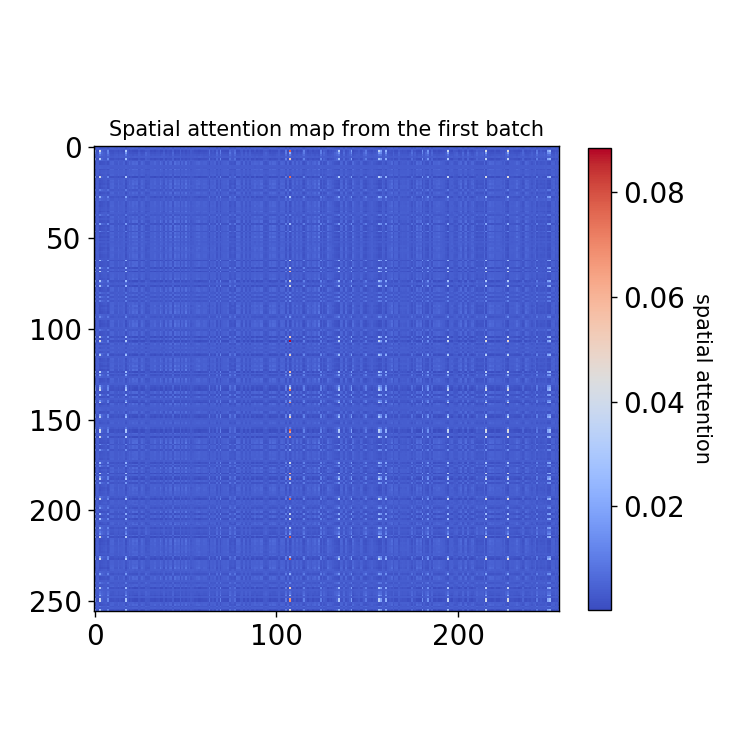

<IPython.core.display.Javascript object>

In [46]:

attention_bn = 0
# attention_bn_2 = 15

attention_S  = ATT_tr[0]
print(attention_S.shape)
fix, axs = plt.subplots(1, figsize=(6,6))
cmaps = ["Reds","Blues","gray_r"]
# axs.imshow(attention[15].cpu().detach().numpy(),cmap=cmaps[2])
im = axs.imshow(attention_S[attention_bn].cpu().detach().numpy(), cmap= plt.cm.coolwarm)

axs.set_title('Spatial attention map from the first batch')
cbar = axs.figure.colorbar(im, ax=axs,shrink=0.8)
cbar.ax.set_ylabel('spatial attention', rotation=-90, va="bottom",fontsize=12)

fix, axs = plt.subplots(1, figsize=(8,4))
cmaps = ["Reds","Blues","gray_r"]
axs.plot(attention_S[attention_bn][21].cpu().detach().numpy())


In [47]:
attention_C  = ATT_tr[1]
print(attention_C.shape)
# attention_bn = 2
fix, axs = plt.subplots(1, figsize=(6,6))
cmaps = ["Reds","Blues","gray_r"]
# axs.imshow(attention[15].cpu().detach().numpy(),cmap=cmaps[2])
im = axs.imshow(attention_C[attention_bn].cpu().detach().numpy(), cmap= plt.cm.coolwarm)
axs.tick_params(labelsize=12)
axs.set_title('Channel attention map from the first batch')
cbar = axs.figure.colorbar(im, ax=axs,shrink=0.8)
cbar.ax.set_ylabel('channel attention', rotation=-90, va="bottom",fontsize=12)
cbar.ax.tick_params(labelsize=12)


torch.Size([1581, 8, 8])


<IPython.core.display.Javascript object>

torch.Size([51, 31, 31])


<IPython.core.display.Javascript object>

Input of spatial and channel attention: torch.Size([1581, 8, 256])


<IPython.core.display.Javascript object>


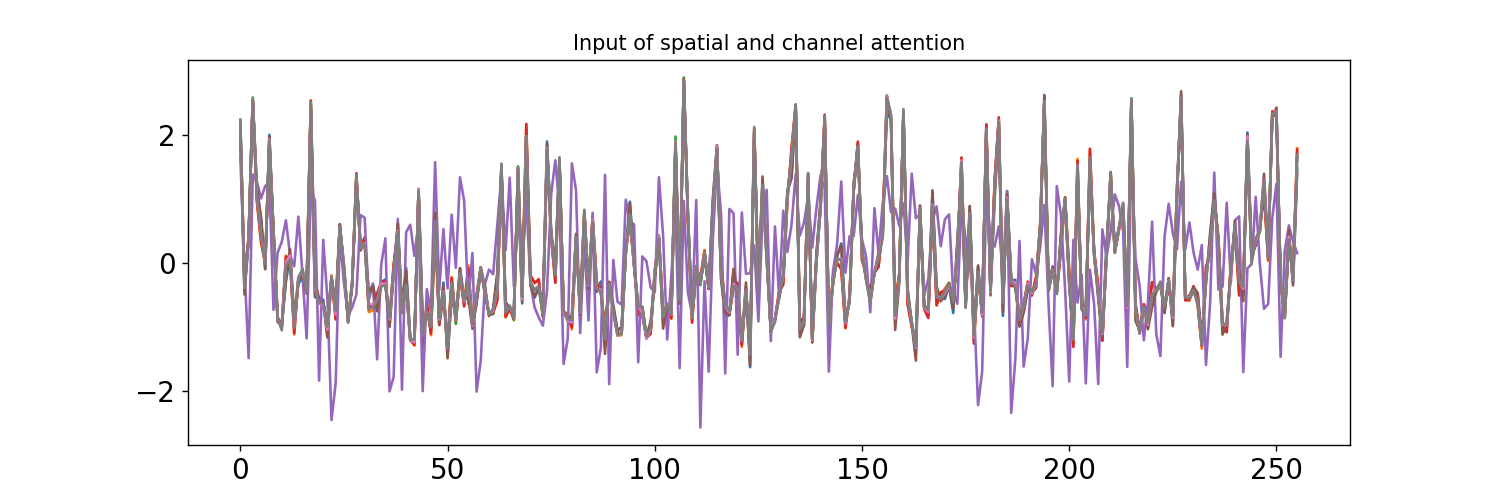

Input of temporal attention: torch.Size([31, 51, 256])


<IPython.core.display.Javascript object>


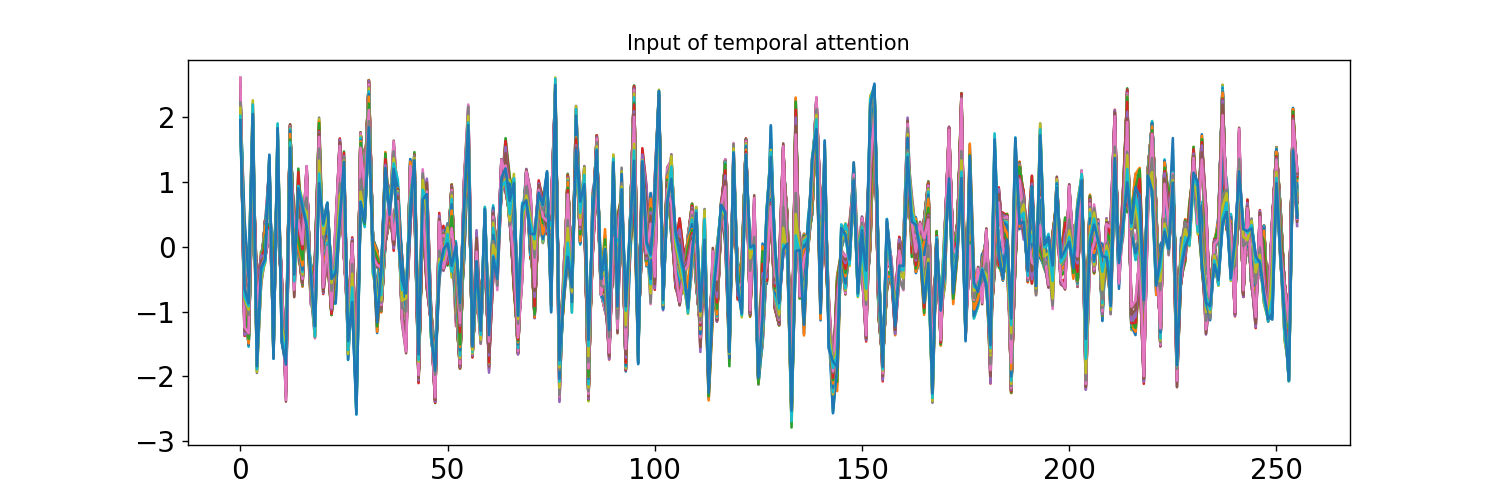

Text(0.5, 1.0, 'Input of temporal attention')

In [48]:
attention_T  = ATT_tr[2]
print(attention_T.shape)
attention_bn = 0
fix, axs = plt.subplots(1, figsize=(6,6))
cmaps = ["Reds","Blues","gray_r"]
# axs.imshow(attention[15].cpu().detach().numpy(),cmap=cmaps[2])
im = axs.imshow(attention_T[attention_bn].cpu().detach().numpy(), cmap= plt.cm.coolwarm)
axs.set_title('Temporal attention in the training dataset')
axs.tick_params(labelsize=12)
cbar = axs.figure.colorbar(im, ax=axs,shrink=0.8)
cbar.ax.set_ylabel('Temporal attention', rotation=-90, va="bottom",fontsize=12)
cbar.ax.tick_params(labelsize=12)
plt.savefig(save_figures_to+"The first batch of temporal attention matrix in the training dataset.png", bbox_inches='tight', dpi=300)

In_Conv_Att = ATT_tr[3]
print('Input of spatial and channel attention:',In_Conv_Att.shape)
# attention_bn = 2
fix, axs = plt.subplots(1, figsize=(12,4))
cmaps = ["Reds","Blues","gray_r"]
# axs.imshow(attention[15].cpu().detach().numpy(),cmap=cmaps[2])
im = axs.plot(In_Conv_Att[attention_bn].t().cpu().detach().numpy())
axs.set_title('Input of spatial and channel attention')


In_Conv_Att = ATT_tr[4]
print('Input of temporal attention:',In_Conv_Att.shape)
# attention_bn = 2
fix, axs = plt.subplots(1, figsize=(12,4))
cmaps = ["Reds","Blues","gray_r"]
# axs.imshow(attention[15].cpu().detach().numpy(),cmap=cmaps[2])
im = axs.plot(In_Conv_Att[attention_bn].t().cpu().detach().numpy())
axs.set_title('Input of temporal attention')

In [49]:
# model.save()
# model.load(CNN_ATT_SCT_PATH)

## Classification result, test dataset

In [50]:
# Ntn=349
y2_temp = torch.cat([torch.zeros(Ntn_0),torch.ones(Ntn-Ntn_0)]).to(device) # Store the label of each spectral curve.
print(X2t.shape,X2.shape)

torch.Size([349, 4023]) torch.Size([1581, 4023])


In [51]:
print(X2.shape,X2t.shape,N)

torch.Size([1581, 4023]) torch.Size([349, 4023]) 4023


In [52]:
X2t_TEST = X2t.unsqueeze(1)
with torch.no_grad(): 
    y2t, ATT_t= model(X2t_TEST)# use model in each bin to predict label of test data curves belong to each bin             
y2t_pred = y2t>0.5 
y2t_pred = torch.squeeze(y2t_pred)
# FinlPredLabel =y2t_pred.cpu().numpy().astype(int)
FinlPredLabel =1*y2t_pred.cpu()
print(y2t_pred[1:5],y2t_pred.shape)

print(FinlPredLabel.shape,FinlPredLabel)
        

<class 'torch.Tensor'> torch.Size([349, 1, 256])
Conv output: torch.Size([349, 8, 500])
embeding output/In_Conv_Att: torch.Size([349, 8, 256])
In_Conv_Att_S: torch.Size([256, 349, 8])
In_Conv_Att_S: torch.Size([256, 349, 8])
In_Att_C,attention_C: torch.Size([349, 8, 256]) torch.Size([349, 8, 8])
In_Att_S,attention_S: torch.Size([256, 349, 8]) torch.Size([349, 256, 256])
Spatial attention output shape: torch.Size([349, 8, 256])
dec_conv3: torch.Size([349, 1, 256])
dec_conv3, output_dimension_fc: torch.Size([349, 256]) 256 500
tensor([False, False, False, False], device='cuda:0') torch.Size([349])
torch.Size([349]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Attention matrixs in the test set.

torch.Size([349, 256, 256])


<IPython.core.display.Javascript object>


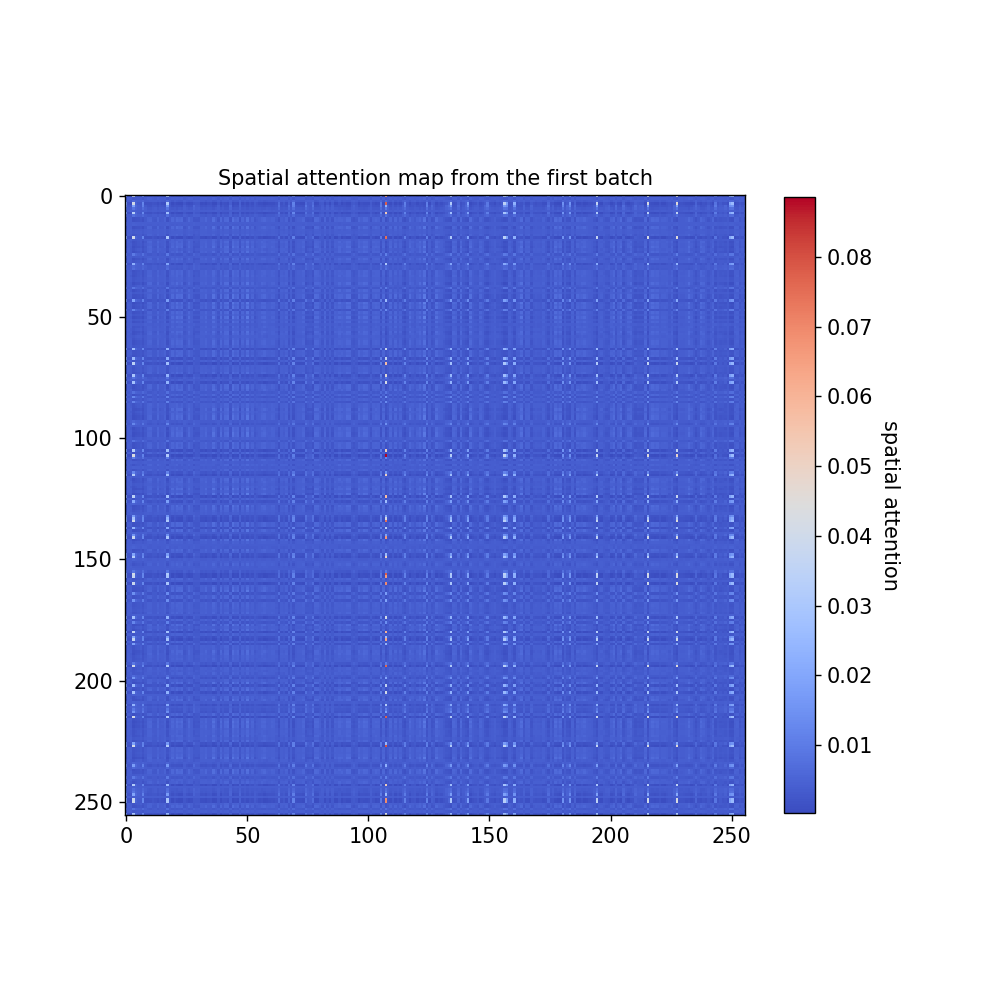

<IPython.core.display.Javascript object>


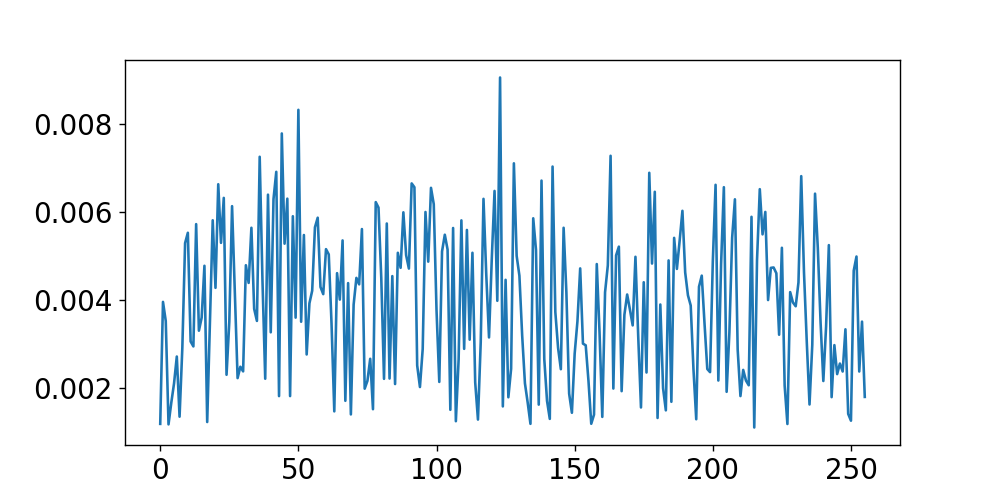

In [53]:
attention_S  = ATT_t[0]
print(attention_S.shape)
attention_bn = 0
fix, axs = plt.subplots(1, figsize=(8,8))
cmaps = ["Reds","Blues","gray_r"]
# axs.imshow(attention[15].cpu().detach().numpy(),cmap=cmaps[2])
im = axs.imshow(attention_S[attention_bn].cpu().detach().numpy(), cmap= plt.cm.coolwarm)
axs.tick_params(labelsize=12)

axs.set_title('Spatial attention map from the first batch')
cbar = axs.figure.colorbar(im, ax=axs,shrink=0.8)
cbar.ax.set_ylabel('spatial attention', rotation=-90, va="bottom",fontsize=12)
cbar.ax.tick_params(labelsize=12)

fix, axs = plt.subplots(1, figsize=(8,4))
cmaps = ["Reds","Blues","gray_r"]
axs.plot(attention_S[attention_bn][21].cpu().detach().numpy())


torch.Size([349, 256, 256])


<IPython.core.display.Javascript object>


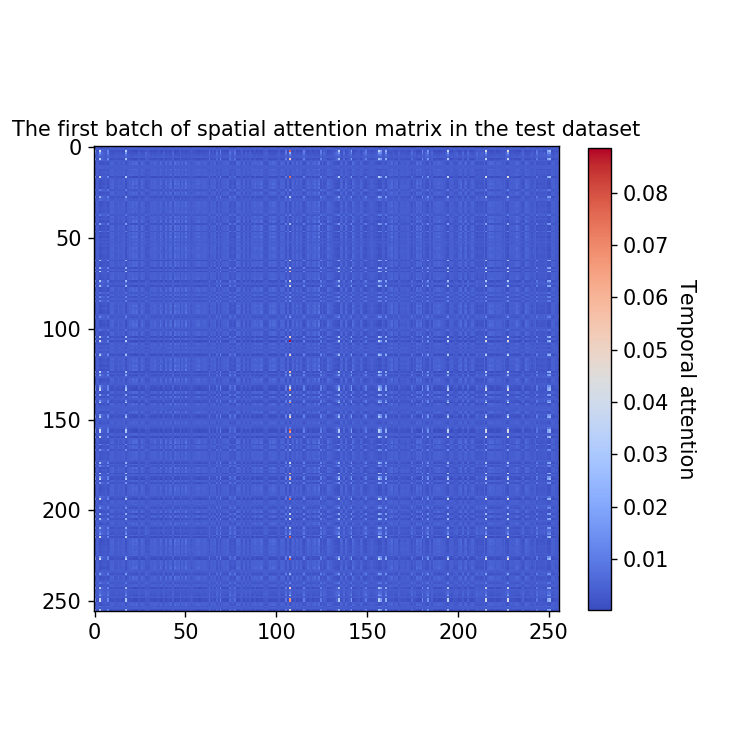

Input of spatial and channel attention: torch.Size([349, 8, 256])


<IPython.core.display.Javascript object>


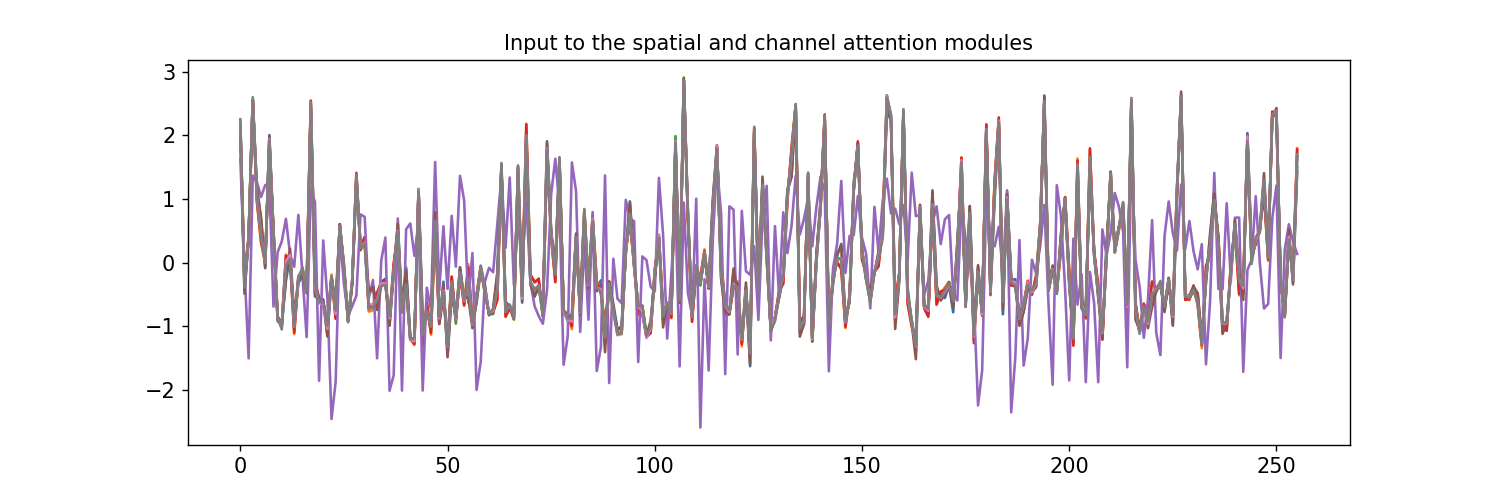

Text(0.5, 1.0, 'Input to the spatial and channel attention modules')

In [54]:
attention_T  = ATT_t[0]
print(attention_T.shape)
# attention_bn = 2
fix, axs = plt.subplots(1, figsize=(6,6))
cmaps = ["Reds","Blues","gray_r"]
# axs.imshow(attention[15].cpu().detach().numpy(),cmap=cmaps[2])
im = axs.imshow(attention_T[attention_bn].cpu().detach().numpy(), cmap= plt.cm.coolwarm)
axs.tick_params(labelsize=12)
axs.set_title('The first batch of spatial attention matrix in the test dataset')
cbar = axs.figure.colorbar(im, ax=axs,shrink=0.8)
cbar.ax.set_ylabel('Temporal attention', rotation=-90, va="bottom",fontsize=12)
cbar.ax.tick_params(labelsize=12)




In_Conv_Att =  ATT_t[3]
print('Input of spatial and channel attention:',In_Conv_Att.shape)
# attention_bn = 2
fix, axs = plt.subplots(1, figsize=(12,4))
axs.tick_params(axis='both', which='major', labelsize=12)
axs.tick_params(axis='both', which='minor', labelsize=10)
cmaps = ["Reds","Blues","gray_r"]
# axs.imshow(attention[15].cpu().detach().numpy(),cmap=cmaps[2])
# im = axs.imshow(In_Conv_Att[attention_bn].cpu().detach().numpy(), cmap= plt.cm.coolwarm)
im = axs.plot(In_Conv_Att[attention_bn].t().cpu().detach().numpy())
axs.set_title('Input to the spatial and channel attention modules')


(256, 256) (256, 256) (8, 256) (8, 256)
0.00028275783 0.088567026 -2.589472 2.9069722


<IPython.core.display.Javascript object>


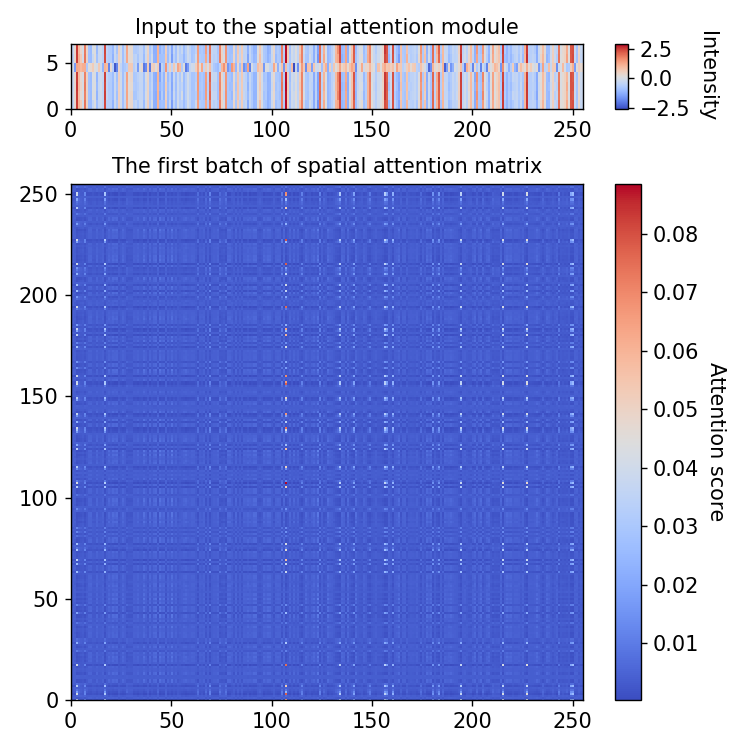

In [55]:
# make these smaller to increase the resolution
dx, dy = 1, 1

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(0, In_Conv_Att.shape[-1] , dy),
                slice(0, In_Conv_Att.shape[-1] , dx)]
yin, xin = np.mgrid[slice(0, In_Conv_Att.shape[1] , dy),
                slice(0, In_Conv_Att.shape[-1] , dx)]
z = attention_S[attention_bn].cpu().detach().numpy()
zin = In_Conv_Att[attention_bn].cpu().detach().numpy()

print(y.shape,z.shape,yin.shape, zin.shape)
z_min, z_max = z.min(), z.max()
zin_min, zin_max = zin.min(), zin.max()
print(z_min,z_max,zin_min,zin_max)

fig, axs = plt.subplots(2, 1,figsize=(6,6), gridspec_kw={'height_ratios': [1, 8]})

ax = axs[0]
axs[0].tick_params(labelsize=12)
c = ax.pcolormesh(xin, yin, zin, cmap=plt.cm.coolwarm, vmin=zin_min, vmax=zin_max)
ax.set_title('Input to the spatial attention module',fontsize=12)
cbar = fig.colorbar(c, ax=ax,aspect=5)
cbar.ax.set_ylabel('Intensity', rotation=-90, va="bottom",fontsize=12)
cbar.ax.tick_params(labelsize=12)

ax = axs[1]
axs[1].tick_params(labelsize=12)
c = ax.pcolor(x, y, z, cmap=plt.cm.coolwarm, vmin=z_min, vmax=z_max)  #contourf
ax.set_title('The first batch of spatial attention matrix',fontsize=12)
cbar = fig.colorbar(c, ax=ax)
cbar.ax.set_ylabel('Attention score', rotation=-90, va="bottom",fontsize=12)
cbar.ax.tick_params(labelsize=12)


fig.tight_layout()
# plt.show()
# ax = axs[1, 1]
# c = ax.pcolorfast(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
# ax.set_title('pcolorfast')
# fig.colorbar(c, ax=ax)

plt.savefig(save_figures_to+"The first batch of spatial attention matrix in the test dataset.png", bbox_inches='tight', dpi=300)


torch.Size([349, 8, 8])


<IPython.core.display.Javascript object>


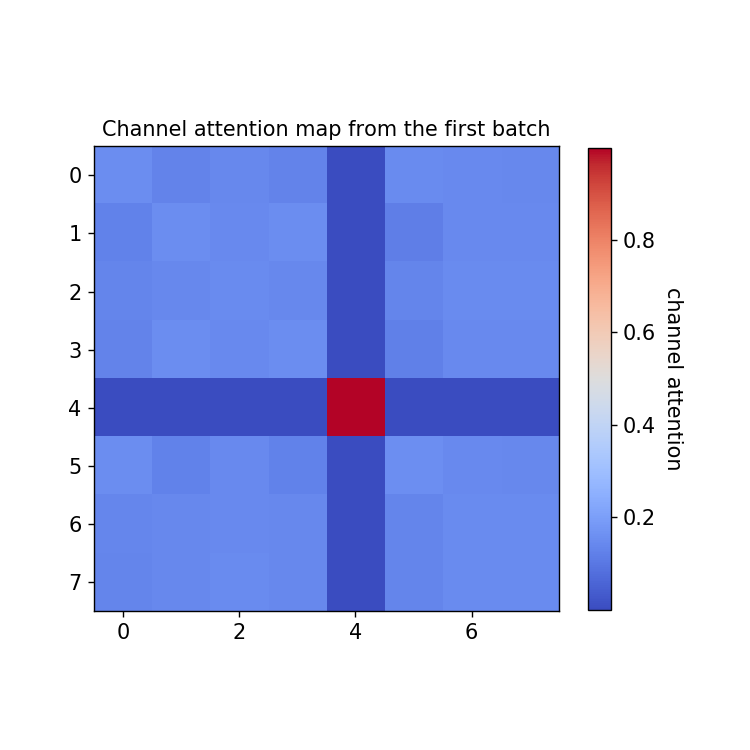

Input of spatial and channel attention: torch.Size([349, 8, 256])


<IPython.core.display.Javascript object>


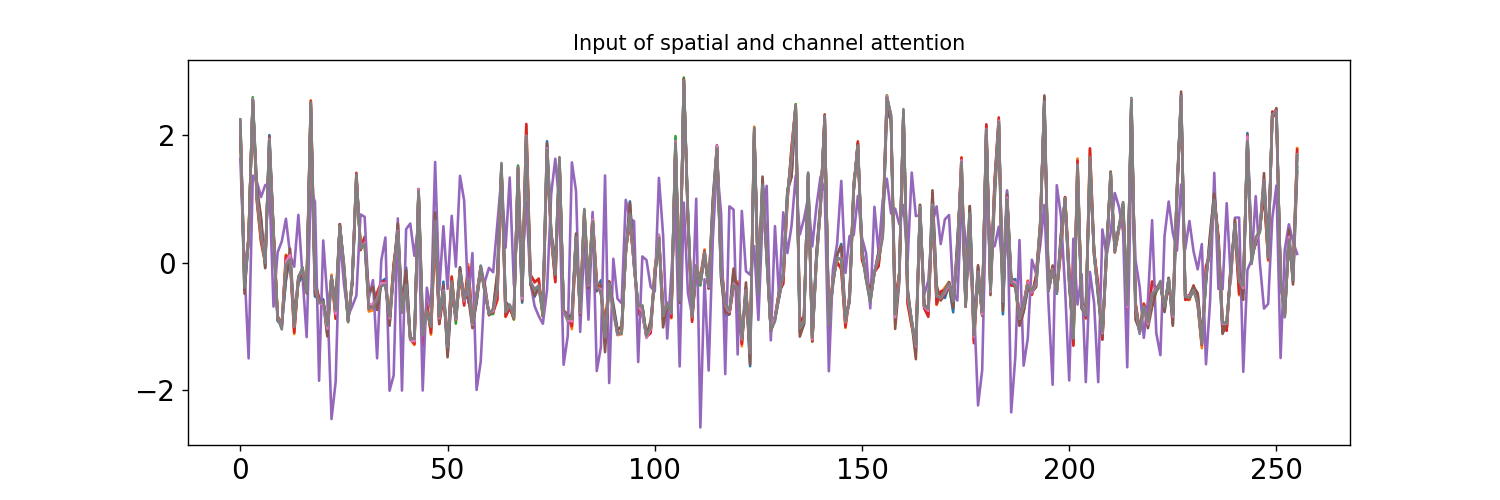

Text(0.5, 1.0, 'Input of spatial and channel attention')

In [56]:
attention_C  = ATT_t[1]
print(attention_C.shape)
# attention_bn = 2
fix, axs = plt.subplots(1, figsize=(6,6))
cmaps = ["Reds","Blues","gray_r"]
# axs.imshow(attention[15].cpu().detach().numpy(),cmap=cmaps[2])
im = axs.imshow(attention_C[attention_bn].cpu().detach().numpy(), cmap= plt.cm.coolwarm)
axs.set_title('Channel attention map from the first batch')
axs.tick_params(labelsize=12)
cbar = axs.figure.colorbar(im, ax=axs,shrink=0.8)
cbar.ax.set_ylabel('channel attention', rotation=-90, va="bottom",fontsize=12)
cbar.ax.tick_params(labelsize=12)
plt.savefig(save_figures_to+"The first batch of channel attention matrix in the test dataset.png", bbox_inches='tight', dpi=300)


In_Conv_Att =  ATT_t[3]
print('Input of spatial and channel attention:',In_Conv_Att.shape)
# attention_bn = 2
fix, axs = plt.subplots(1, figsize=(12,4))
cmaps = ["Reds","Blues","gray_r"]
# axs.imshow(attention[15].cpu().detach().numpy(),cmap=cmaps[2])
# im = axs.imshow(In_Conv_Att[attention_bn].cpu().detach().numpy(), cmap= plt.cm.coolwarm)
im = axs.plot(In_Conv_Att[attention_bn].t().cpu().detach().numpy())
axs.set_title('Input of spatial and channel attention')


torch.Size([1, 349, 349])


<IPython.core.display.Javascript object>


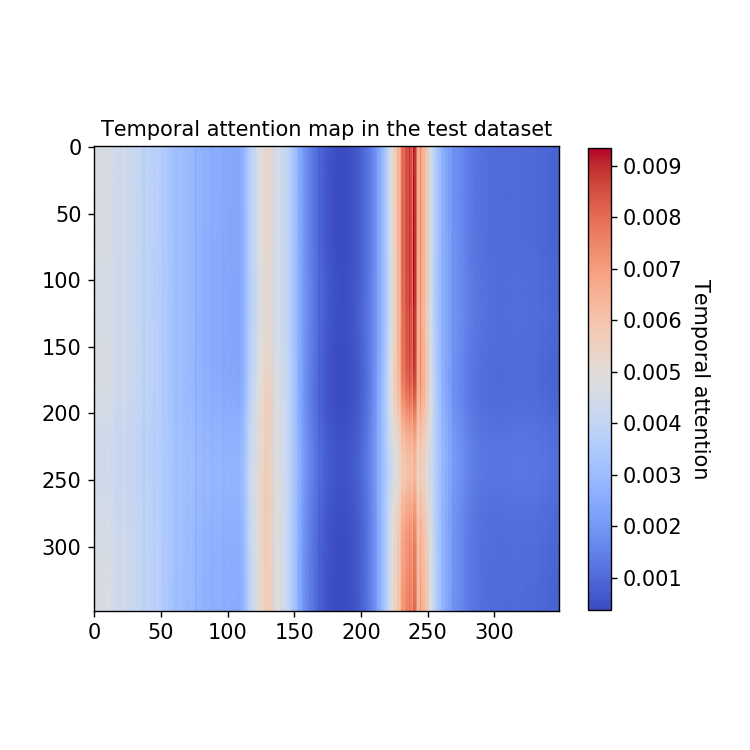

Input of temporal attention: torch.Size([349, 1, 256])


<IPython.core.display.Javascript object>


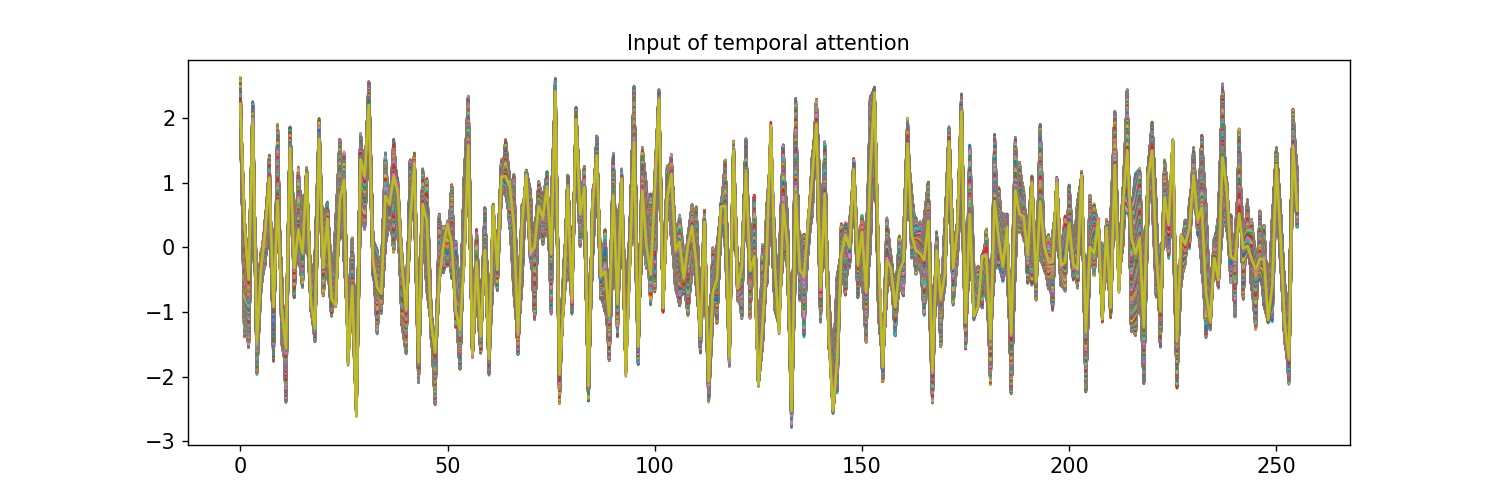

Text(0.5, 1.0, 'Input of temporal attention')

In [57]:

attention_T  = ATT_t[2]
print(attention_T.shape)
# attention_bn = 2
fix, axs = plt.subplots(1, figsize=(6,6))
cmaps = ["Reds","Blues","gray_r"]
# axs.imshow(attention[15].cpu().detach().numpy(),cmap=cmaps[2])
im = axs.imshow(attention_T[attention_bn].cpu().detach().numpy(), cmap= plt.cm.coolwarm)
axs.tick_params(labelsize=12)
axs.set_title('Temporal attention map in the test dataset')
cbar = axs.figure.colorbar(im, ax=axs,shrink=0.8)
cbar.ax.set_ylabel('Temporal attention', rotation=-90, va="bottom",fontsize=12)
cbar.ax.tick_params(labelsize=12)
plt.savefig(save_figures_to+"The first batch of temporal attention matrix in the test dataset.png", bbox_inches='tight', dpi=300)


In_Conv_Att = ATT_t[4]
print('Input of temporal attention:',In_Conv_Att.shape)
# attention_bn = 2
fix, axs = plt.subplots(1, figsize=(12,4))
axs.tick_params(axis='both', which='major', labelsize=12)
axs.tick_params(axis='both', which='minor', labelsize=10)
cmaps = ["Reds","Blues","gray_r"]
# axs.imshow(attention[15].cpu().detach().numpy(),cmap=cmaps[2])
im = axs.plot(In_Conv_Att[:,attention_bn,:].t().cpu().detach().numpy())
axs.set_title('Input of temporal attention',fontsize=12)



In [58]:
# with torch.no_grad(): 
#     y_pred, ATT_t = model(X2_TRN) # 
#     y_pred= y_pred.squeeze(0)
# y_pred = (y_pred>0.5)*1

# print(y_pred.t(),y_pred.shape)

## Curve-wise ambigious region 

**Classification Confidence:** $P_{conf} = 1 − N_{f}/N_{t} $

where $N_{f}$ represents the number of spectral curves in the
classification boundary or ambiguous region with the class label jump, $N_{t}$ represents the
number of all the tested spectral curves.

In [59]:
    var_C0=0 # initial value of class 0;
    for j in range(Ntn-1): # test data sets(curves)    
        if (FinlPredLabel[j] == 0) and (FinlPredLabel[(j+1)]==0):
            var_C0 = j+1
        else:
            break  
    var_C1=Ntn-1 # initial value of class 1; So after iteration, if var_C1=Ntn-1(still this value), it means the following conditions are not met.
    for j in range(Ntn-1,0,-1): # test data sets(curves)   
        if (FinlPredLabel[j] == 1) and (FinlPredLabel[(j-1)]==1):
            var_C1 = j-1
        else:
            break
    torch.set_printoptions(threshold=10_000)
    np.set_printoptions(threshold=10_000)
     
    if var_C0==Ntn-1:
        Glo_acc = 0.50
        print("Interval with low classification confidence is (%i ,  %i)" % (var_C0,  var_C1))
        print("The boundary is not found  and all curves are labeled as 0.")
    elif var_C1==0:
        Glo_acc = 0.50
        print("Interval with low classification confidence is (%i ,  %i)" % (var_C0,  var_C1))
        print("The boundary is not found and all curves are labeled as 1.")
    elif var_C0==0 and var_C1==Ntn-1:
        Glo_acc = 0.00
        print("Interval with low classification confidence is (%i ,  %i)" % (var_C0,  var_C1))
        print("The boundary is not found  and all curves are labeled as 1." )
    else:
        Glo_acc = 1-float((var_C1-var_C0-1)/Ntn)
        print("Interval with low classification confidence is (%i ,  %i)" % (var_C0,  var_C1))
        print("Overall classification confidence is %.3f" % (Glo_acc*100)+"%")
    

Interval with low classification confidence is (189 ,  190)
Overall classification confidence is 100.000%


## Curves near the boundary

In [60]:
if var_C0==Ntn-1:
    p_start0 = 0 # start curve
    p_end0   = Ntn # end curv   
elif var_C1==0:
    p_start0 = 0 # start curve
    p_end0   = Ntn # end curv  
else:
    p_start0 = var_C0-5 if var_C0>5 else  var_C0 # start curve
    p_end0   = var_C1+5  if var_C1+5<=Ntn else Ntn


# p_start = p0_num*gap
# p_end = p_num*gap
print(p_start0,p_end0)

184 195


In [61]:
def Rst_plot_data_cut(Intensity, index, c, gap_bias = 2,  d=0, auto=False, zoom=1,title = 'Classification result',figsize=(8,6)):

    Y = Intensity
    c = np.array(c.cpu())
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    ax.set_ylabel('Intensity', )#fontsize = 16,
 
    plt.rc('xtick') #,labelsize=16
    plt.rc('ytick') #,labelsize=16
    for i in index:
        plt.plot( Y[i]-i*gap_bias, color= "g" if c[i]==0 else ('r' if c[i]==1 else 'b'))        
#         plt.text( int(len(Y[i])/2),Y[i][int(len(Y[i])/2)]-i*gap_bias +0.1, "i={}".format(i) ,size= 12 )
        plt.text( 1500,Y[i][int(len(Y[i])/2)]-i*gap_bias +0.1, "i={}".format(i) ,size= 12 )
    plt.title(title)

<IPython.core.display.Javascript object>


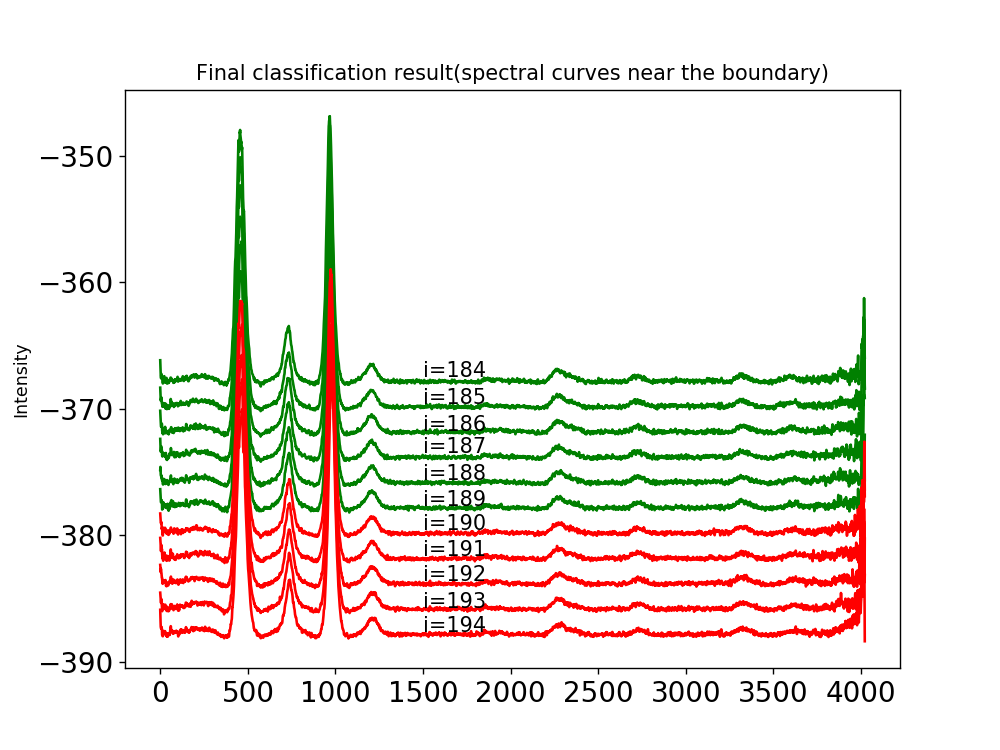

In [62]:

d_index = range(p_start0,p_end0)
Rst_plot_data_cut(X2t.cpu(), d_index, c = FinlPredLabel, title = 'Final classification result(spectral curves near the boundary)')
# Rst_plot_data_cut(intensity_d1[d1_index], d1_index, prob_d1, c = FinlPredLabel_d1[d1_index] , title = 'Classification result d1')

plt.savefig(save_figures_to+"Final classification result_ConvSCT(spectral curves near the boundary).png", bbox_inches='tight', dpi=600)


# 5. Feature importance analysis=====================

x_with_grad shape: torch.Size([31, 51, 4023])
<class 'torch.Tensor'> torch.Size([31, 51, 256])
Conv output: torch.Size([1581, 8, 500])
embeding output/In_Conv_Att: torch.Size([1581, 8, 256])
In_Conv_Att_S: torch.Size([256, 1581, 8])
In_Conv_Att_S: torch.Size([256, 1581, 8])
In_Att_C,attention_C: torch.Size([1581, 8, 256]) torch.Size([1581, 8, 8])
In_Att_S,attention_S: torch.Size([256, 1581, 8]) torch.Size([1581, 256, 256])
Spatial attention output shape: torch.Size([1581, 8, 256])
dec_conv3: torch.Size([1581, 1, 256])
dec_conv3, output_dimension_fc: torch.Size([1581, 256]) 256 500
dydx: torch.Size([31, 51, 4023])
feature importance: torch.Size([4023])


<IPython.core.display.Javascript object>


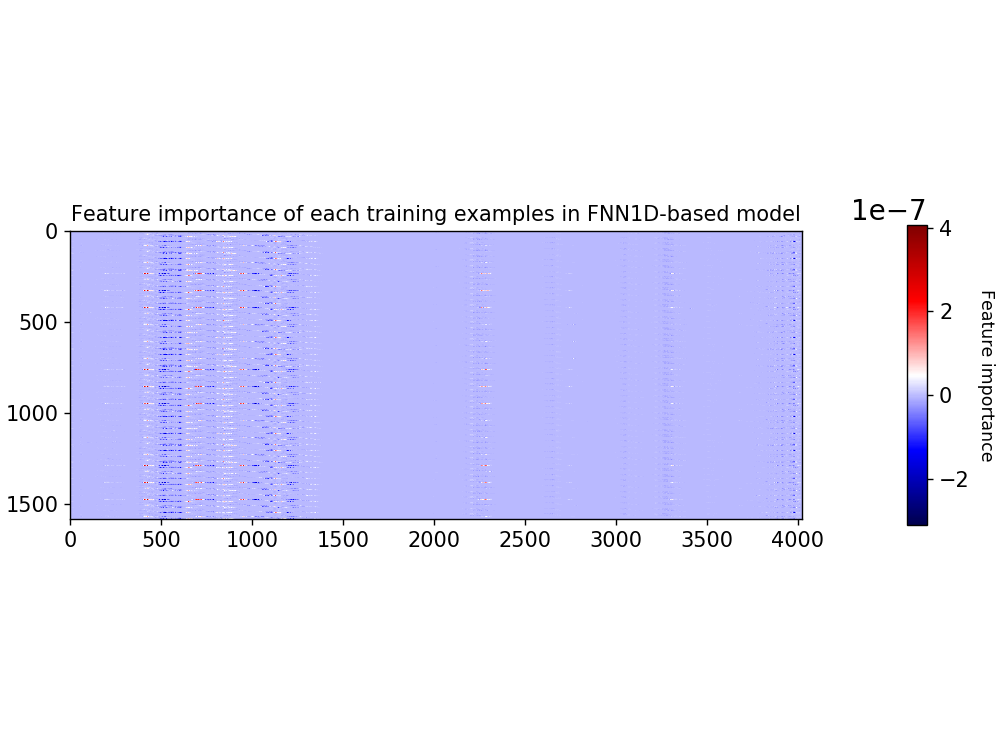

<IPython.core.display.Javascript object>


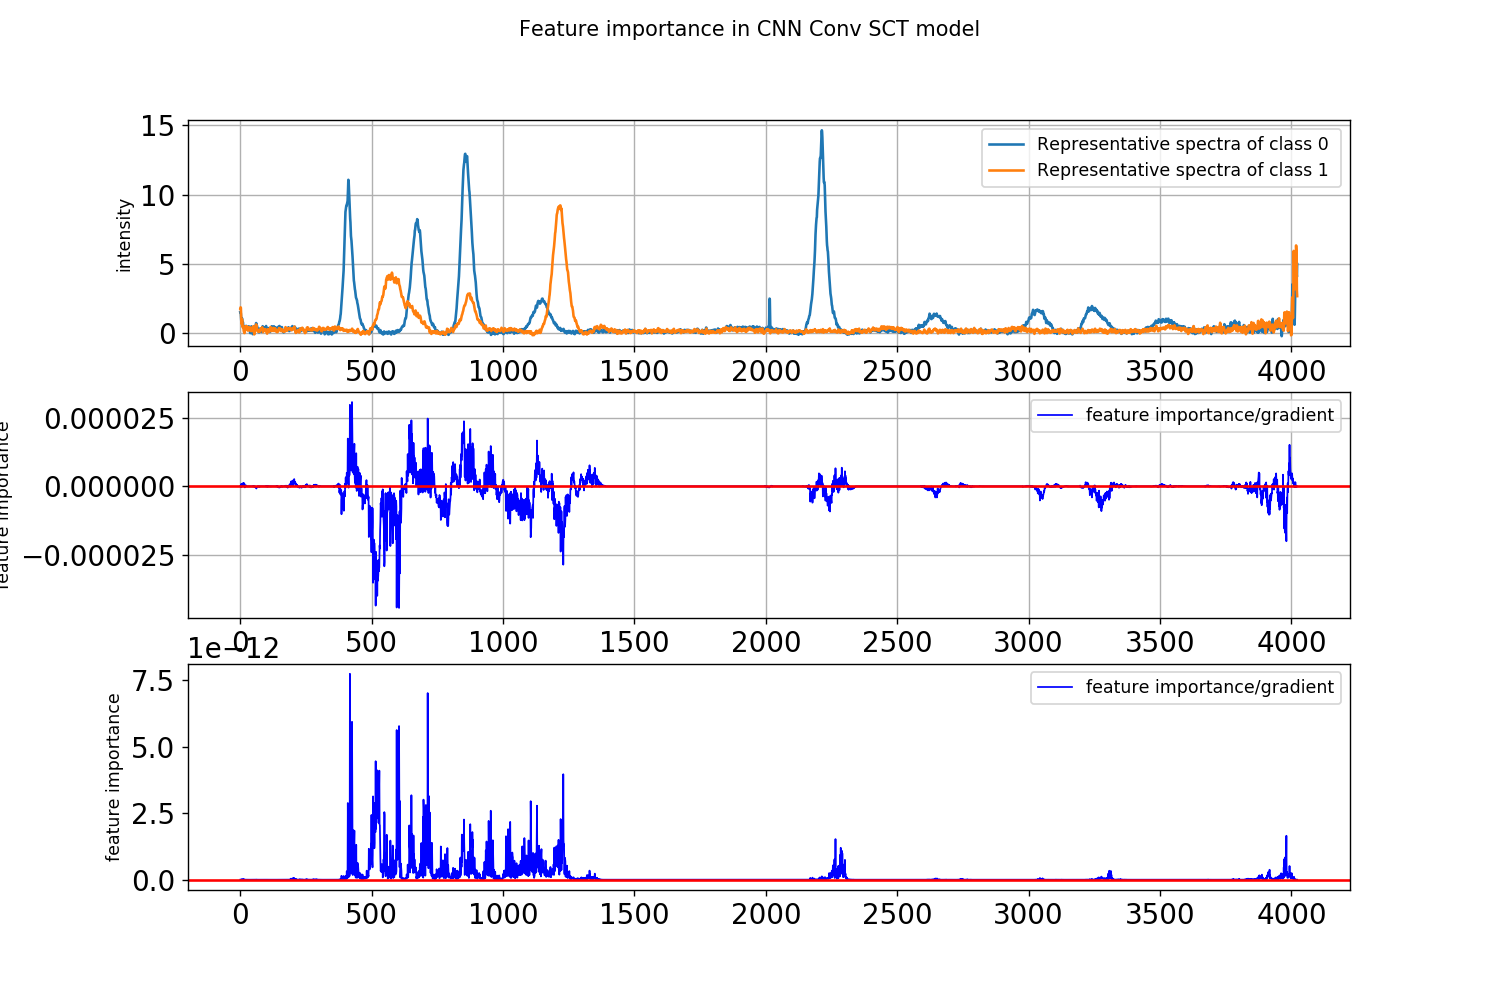

<IPython.core.display.Javascript object>


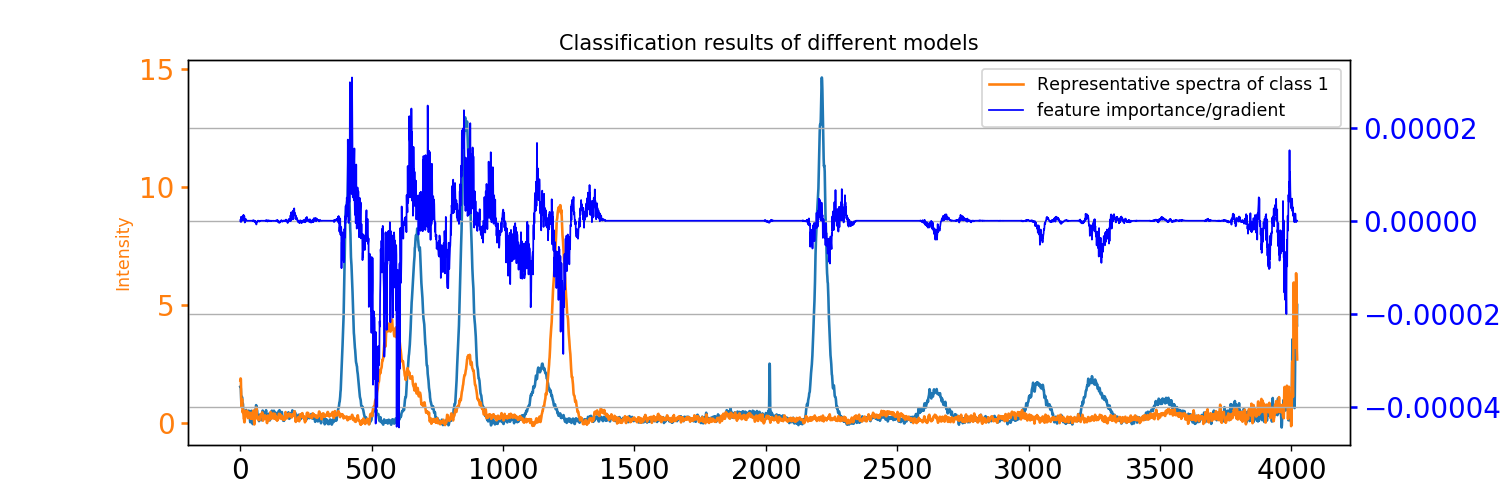

In [63]:
# set model to eval mode
model.zero_grad()
model.eval()

x_att_inp = (X2_TRN)
criterion = torch.nn.BCELoss()
y_true = y2
x_with_grad = torch.autograd.Variable(x_att_inp, requires_grad=True)
print('x_with_grad shape:',x_with_grad.shape)
y_pred,ATT = model.forward(x_with_grad)
y_pred = y_pred.squeeze(0)
loss = criterion(y_pred, y_true)
loss.backward()
# maxypred =  y_pred_o.squeeze(0)
# maxypred.backward()
dydx = x_with_grad.grad
f_impt = torch.sum((torch.squeeze(dydx)),axis=(0,1))
f_impt_s = torch.sum(torch.pow((torch.squeeze(dydx)), 2),axis=(0, 1))
print('dydx:',dydx.shape)
print('feature importance:',f_impt.shape)


fix, axs = plt.subplots(1,  constrained_layout=True)  #figsize=(8,6),
cmaps = ["Reds","Blues","gray_r"]
im = axs.imshow(dydx.view(-1,N).cpu().detach().numpy(),   cmap=cm.seismic)#cmaps[0] cmap= plt.cm.coolwarm
axs.set_title('Feature importance of each training examples in FNN1D-based model')
cbar = axs.figure.colorbar(im, ax=axs,shrink=0.4)
cbar.ax.set_ylabel('Feature importance', rotation=-90, va="bottom") #,labelsize=12
axs.tick_params(labelsize=12)
cbar.ax.tick_params(labelsize=12)


fig, axs = plt.subplots(3, figsize=(12,8))
axs[0].plot(X2t[0].cpu().detach().numpy().T,label='Representative spectra of class 0 ')
axs[0].plot(X2t[-1].cpu().detach().numpy().T, label='Representative spectra of class 1 ')
axs[0].set_ylabel("intensity")
axs[0].legend()
axs[0].grid()
# axs[1].plot(x_with_grad.grad[0].cpu().numpy().T,'b',linewidth=1,label='gradient')
axs[1].plot(f_impt.cpu().numpy(),'b',linewidth=1,label='feature importance/gradient')
axs[1].set_ylabel("feature importance")
axs[1].axhline(y=0, color='r', linestyle='-')
axs[1].legend()
axs[1].grid()
axs[2].plot(f_impt_s.cpu().numpy(),'b',linewidth=1,label='feature importance/gradient')
axs[2].set_ylabel("feature importance")
axs[2].axhline(y=0, color='r', linestyle='-')
axs[2].legend()
plt.suptitle('Feature importance in CNN Conv SCT model')





fig, host = plt.subplots( figsize=(12,4))
par1 = host.twinx()
p1, =host.plot(X2t[0].cpu().detach().numpy().T,label='Representative spectra of class 0 ')
p1, =host.plot(X2t[-1].cpu().detach().numpy().T, label='Representative spectra of class 1 ')
p2, =par1.plot(f_impt.cpu().numpy(),'b',linewidth=1,label='feature importance/gradient')

host.set_ylabel("Intensity")
par1.set_ylabel("Feature importance")
host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
plt.title('Classification results of different models')
lines = [p1, p2]
host.legend(lines, [l.get_label() for l in lines],loc='upper right')
# plt.xticks('',rotation=15) 
plt.grid(True)


# axs[1].plot(np.abs(x_with_grad.grad[0].cpu().numpy()).T,'r',label='absolute gradient')
# axs[1].set_ylabel("dy/dx")

(4023,)


<IPython.core.display.Javascript object>


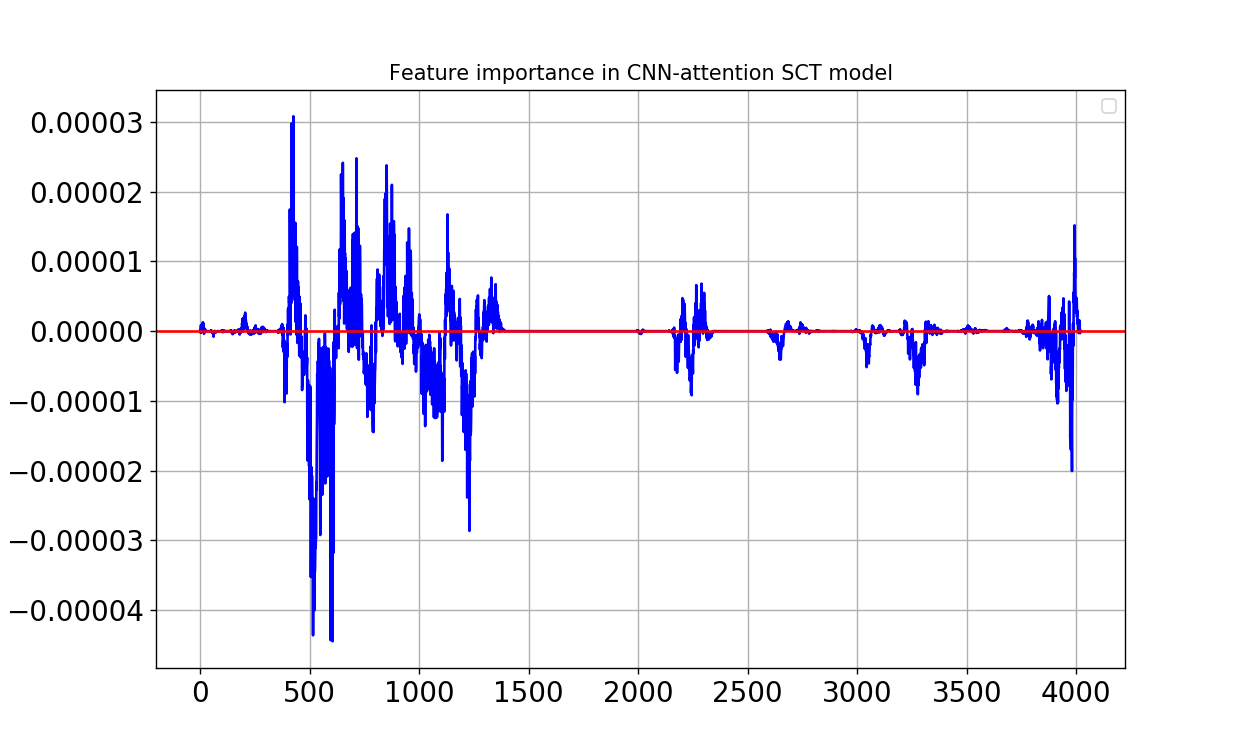

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Feature importance in CNN-attention SCT model')

In [64]:
dat = f_impt.cpu().numpy()
print(dat.shape)
np.savetxt('Convolutional SCT_CAM-FFwd attention model feature importance.txt', dat)

fname = 'Convolutional SCT_CAM-FFwd attention model feature importance.txt'
feature_impt = np.loadtxt(fname, unpack=True) # reads all files in range and assigns 1st column to thetas and 2nd to Is

fig, axs = plt.subplots(1, figsize=(10,6))
axs.plot(feature_impt,'b')
axs.set_ylabel("feature importance")
axs.axhline(y=0, color='r', linestyle='-')
axs.legend()
axs.grid()
plt.title('Feature importance in CNN-attention SCT model')

(4023,)


<IPython.core.display.Javascript object>


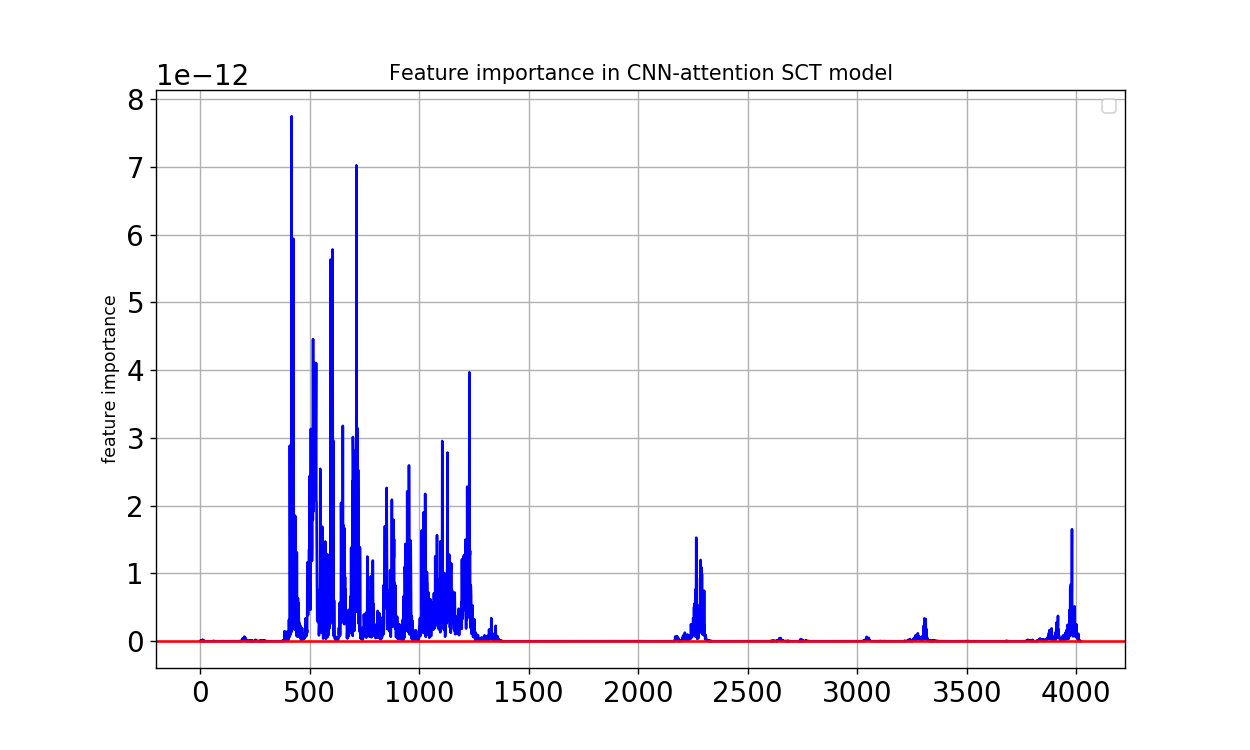

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Feature importance in CNN-attention SCT model')

In [65]:
dat = f_impt_s.cpu().numpy()
print(dat.shape)
np.savetxt('Convolutional SCT_CAM-FFwd attention model feature importance AvgS.txt', dat)

fname = 'Convolutional SCT_CAM-FFwd attention model feature importance AvgS.txt'
feature_impt = np.loadtxt(fname, unpack=True) # reads all files in range and assigns 1st column to thetas and 2nd to Is

fig, axs = plt.subplots(1, figsize=(10,6))
axs.plot(feature_impt,'b')
axs.set_ylabel("feature importance")
axs.axhline(y=0, color='r', linestyle='-')
axs.legend()
axs.grid()
plt.title('Feature importance in CNN-attention SCT model')

x_with_grad shape: torch.Size([1, 4023])
<class 'torch.Tensor'> torch.Size([1, 1, 256])
Conv output: torch.Size([1, 8, 500])
embeding output/In_Conv_Att: torch.Size([1, 8, 256])
In_Conv_Att_S: torch.Size([256, 1, 8])
In_Conv_Att_S: torch.Size([256, 1, 8])
In_Att_C,attention_C: torch.Size([1, 8, 256]) torch.Size([1, 8, 8])
In_Att_S,attention_S: torch.Size([256, 1, 8]) torch.Size([1, 256, 256])
Spatial attention output shape: torch.Size([1, 8, 256])
dec_conv3: torch.Size([1, 1, 256])
dec_conv3, output_dimension_fc: torch.Size([1, 256]) 256 500
dydx: torch.Size([1, 4023])


<IPython.core.display.Javascript object>


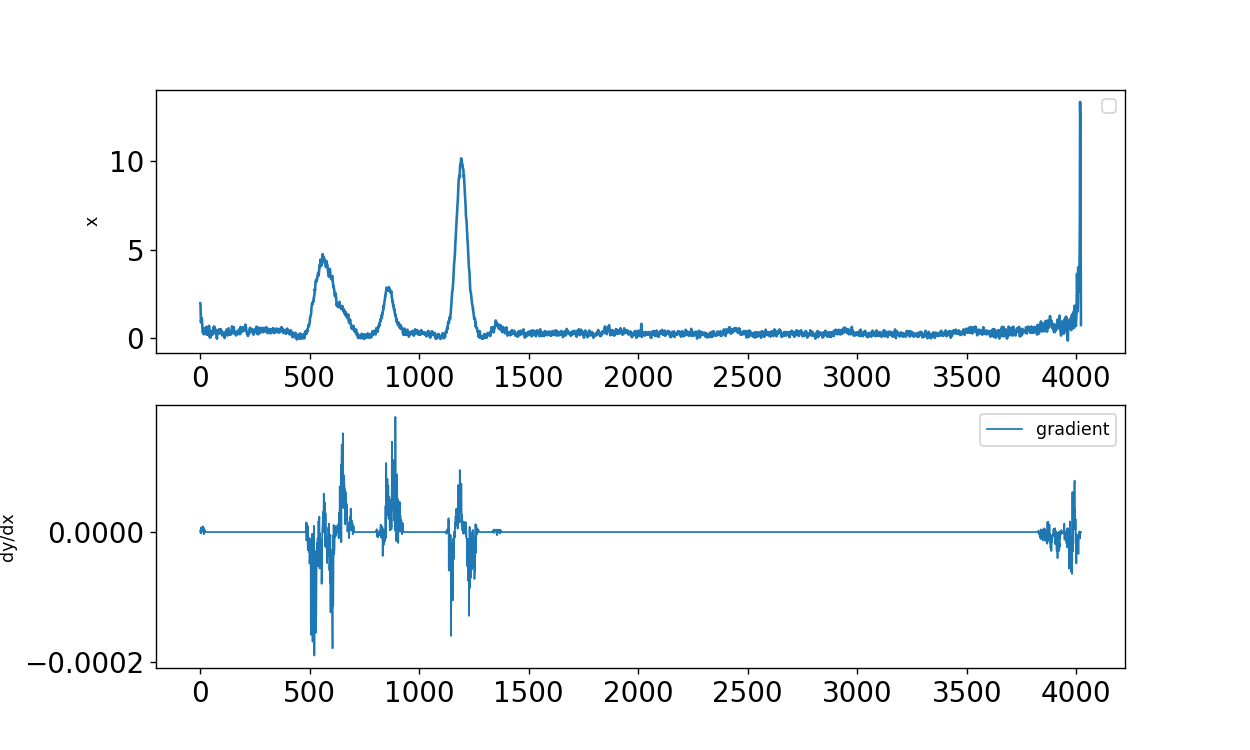

No handles with labels found to put in legend.


In [66]:
x_att_inp = (X2[-2:-1,:])
criterion = torch.nn.BCELoss()
y_true = y2[-2:-1,:]
x_with_grad = torch.autograd.Variable(x_att_inp, requires_grad=True)
print('x_with_grad shape:',x_with_grad.shape)
y_pred,ATT = model.forward(x_with_grad)
# y_pred = y_pred.squeeze(0)
loss = criterion(y_pred, y_true)
loss.backward()
# maxypred =  y_pred_o.squeeze(0)
# maxypred.backward()
dydx = x_with_grad.grad
print('dydx:',dydx.shape)


fig, axs = plt.subplots(2, figsize=(10,6))
axs[0].plot(x_with_grad[0].cpu().detach().numpy().T)
axs[0].set_ylabel("x")
axs[0].legend()
axs[1].plot(x_with_grad.grad[0].cpu().numpy().T,linewidth=1,label='gradient')
axs[1].set_ylabel("dy/dx")
# axs[1].plot(np.abs(x_with_grad.grad[0].cpu().numpy()).T,'r',label='absolute gradient')
# axs[1].set_ylabel("dy/dx")
axs[1].legend()

In [67]:
csvdir = model_path
import pandas as pd
BANDS = ['feature']
df = pd.DataFrame(x_with_grad.grad[0].t().cpu().numpy() ,columns=BANDS) #
df.index.name="feature number"
df.to_csv(os.path.join(csvdir,  "dydx.csv"))#"transformer",
print("writing: "+os.path.join(csvdir,  "dydx.csv")) #"transformer",

writing: /gpfs/exfel/data/user/sunyue/Mybinder_test/ModelPath/dydx.csv


In [68]:
x_with_grad.grad[0].t().shape

torch.Size([4023])

torch.Size([349, 256, 256])


<IPython.core.display.Javascript object>


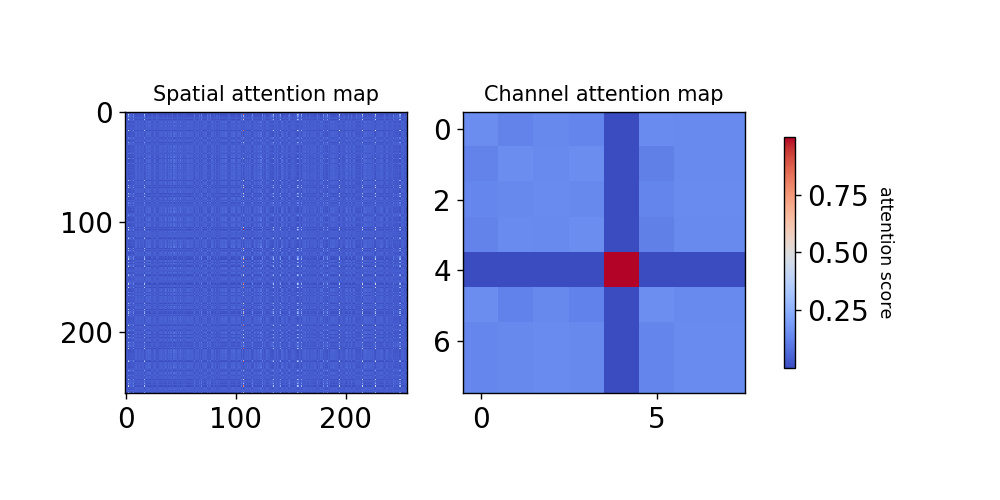

torch.Size([349, 8, 8])


Text(0, 0.5, 'attention score')

In [69]:
print(attention_S.shape)
attention_bn = 2
fix, axs = plt.subplots(1,2, figsize=(8,4))
cmaps = ["Reds","Blues","gray_r"]
# axs.imshow(attention[15].cpu().detach().numpy(),cmap=cmaps[2])
im= axs[0].imshow(attention_S[attention_bn].cpu().detach().numpy(), cmap= plt.cm.coolwarm)
axs[0].set_title('Spatial attention map')
# cbar = axs[0].figure.colorbar(im, ax=axs,shrink=0.8)
# cbar.ax.set_ylabel('spatial attention', rotation=-90, va="bottom")

# fix, axs = plt.subplots(1, figsize=(8,4))
# cmaps = ["Reds","Blues","gray_r"]
# axs.plot(attention_S[attention_bn][21].cpu().detach().numpy())


print(attention_C.shape)
# attention_bn = 2
cmaps = ["Reds","Blues","gray_r"]
# axs.imshow(attention[15].cpu().detach().numpy(),cmap=cmaps[2])
im = axs[1].imshow(attention_C[attention_bn].cpu().detach().numpy(), cmap= plt.cm.coolwarm)
axs[1].set_title('Channel attention map')
cbar = axs[1].figure.colorbar(im, ax=axs,shrink=0.6)
cbar.ax.set_ylabel('attention score', rotation=-90, va="bottom")


In [70]:
X2t[0:-1].shape
print(X2t[0:-1:1].shape)
np.arange(1,1,10)

torch.Size([348, 4023])


array([], dtype=int64)

x_with_grad shape: torch.Size([349, 1, 4023])
<class 'torch.Tensor'> torch.Size([349, 1, 256])
Conv output: torch.Size([349, 8, 500])
embeding output/In_Conv_Att: torch.Size([349, 8, 256])
In_Conv_Att_S: torch.Size([256, 349, 8])
In_Conv_Att_S: torch.Size([256, 349, 8])
In_Att_C,attention_C: torch.Size([349, 8, 256]) torch.Size([349, 8, 8])
In_Att_S,attention_S: torch.Size([256, 349, 8]) torch.Size([349, 256, 256])
Spatial attention output shape: torch.Size([349, 8, 256])
dec_conv3: torch.Size([349, 1, 256])
dec_conv3, output_dimension_fc: torch.Size([349, 256]) 256 500
dydx: torch.Size([349, 1, 4023])
feature importance: torch.Size([4023])


<IPython.core.display.Javascript object>


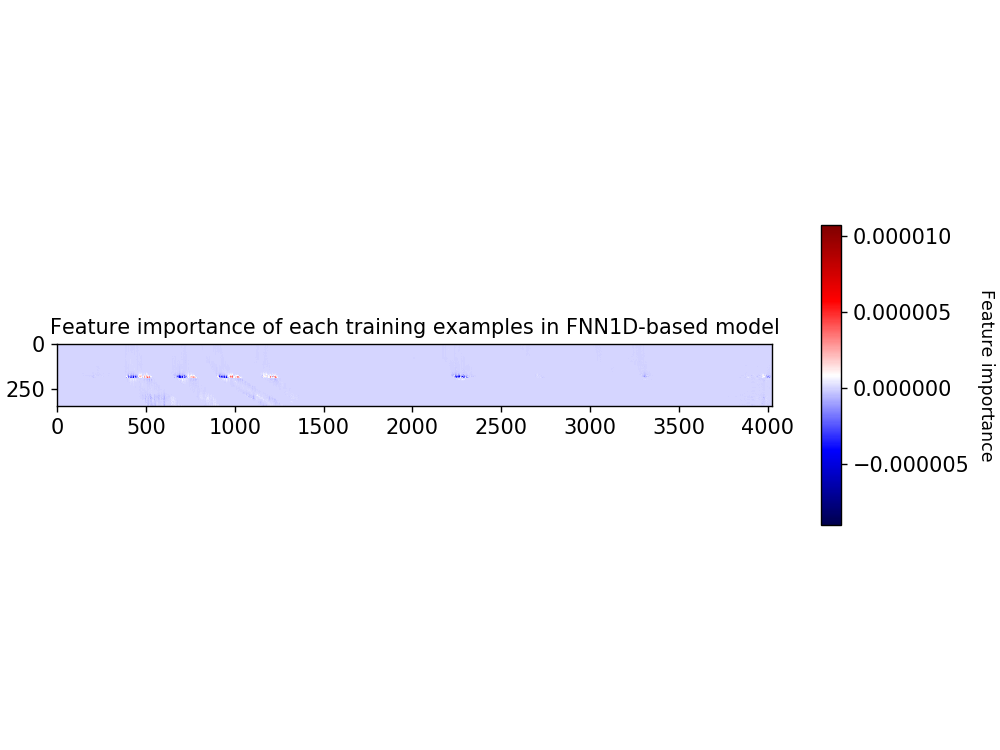

<IPython.core.display.Javascript object>


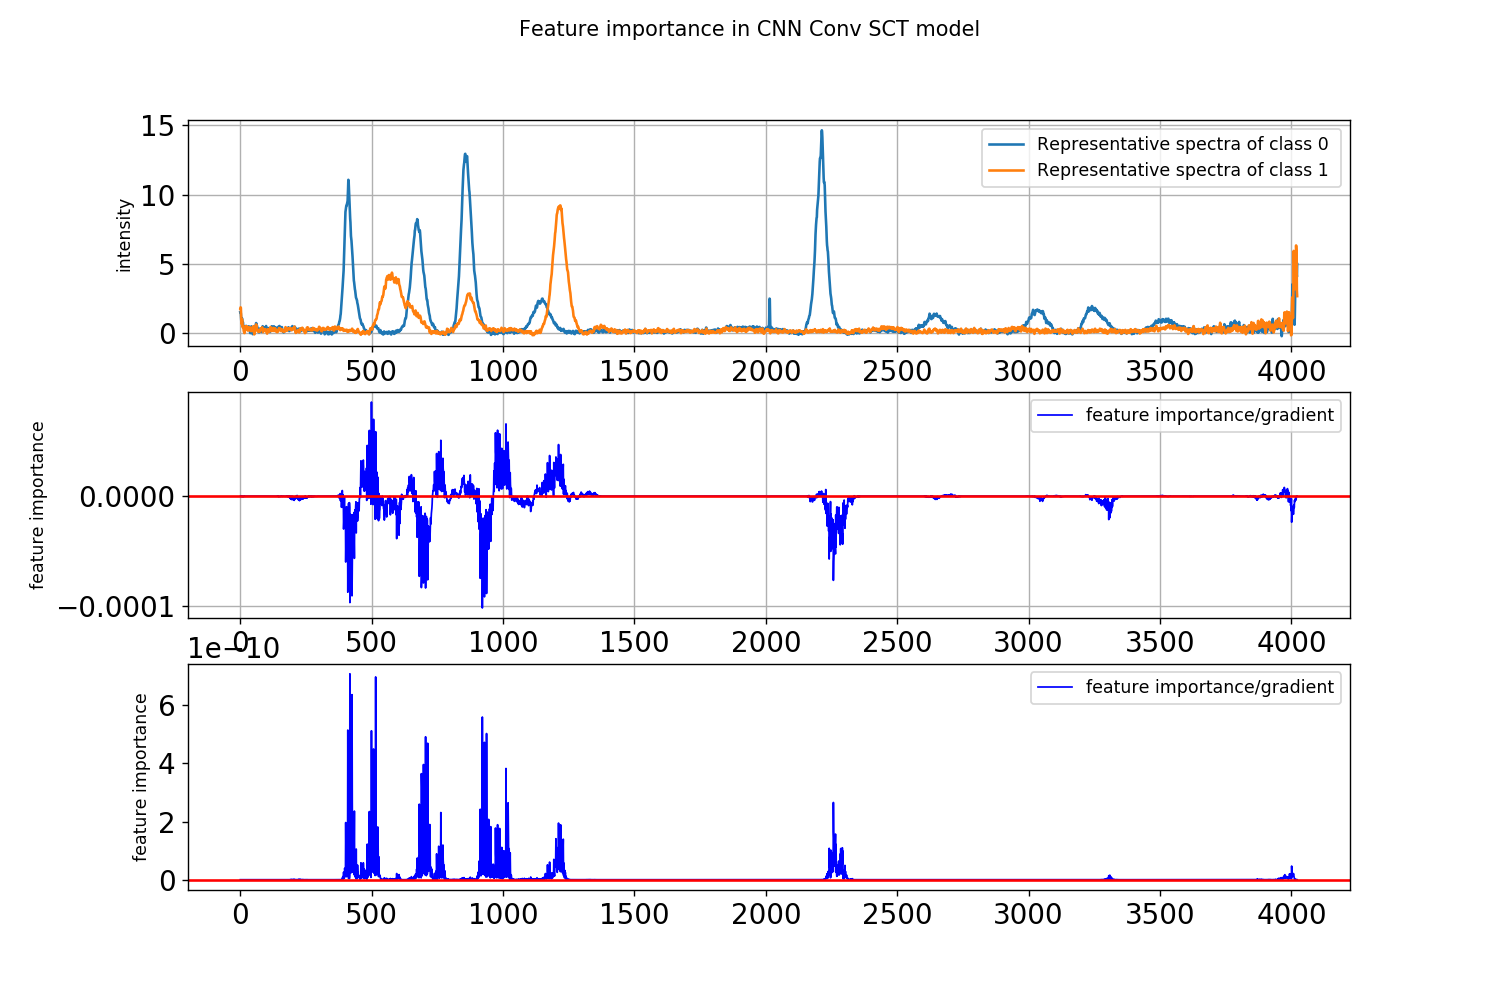

<IPython.core.display.Javascript object>


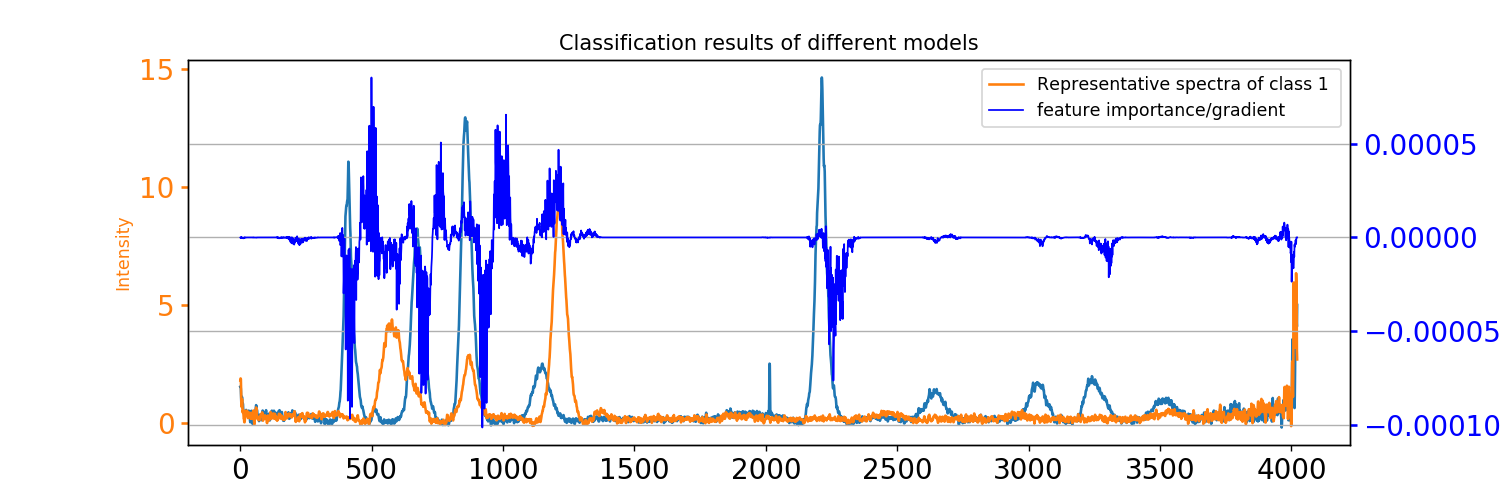

In [71]:
# set model to eval mode
model.zero_grad()
model.eval()

x_att_inp = (X2t_TEST)
criterion = torch.nn.BCELoss()
y_true = y2t
x_with_grad = torch.autograd.Variable(x_att_inp, requires_grad=True)
print('x_with_grad shape:',x_with_grad.shape)
y_pred,ATT = model.forward(x_with_grad)
y_pred = y_pred.squeeze(0)
loss = criterion(y_pred, y_true)
loss.backward()
# maxypred =  y_pred_o.squeeze(0)
# maxypred.backward()
dydx = x_with_grad.grad
f_impt = torch.sum((torch.squeeze(dydx)),axis=0)
f_impt_s = torch.sum(torch.pow((torch.squeeze(dydx)), 2),axis=0)
print('dydx:',dydx.shape)
print('feature importance:',f_impt.shape)


fix, axs = plt.subplots(1,  constrained_layout=True)  #figsize=(8,6),
cmaps = ["Reds","Blues","gray_r"]
im = axs.imshow(dydx.view(-1,N).cpu().detach().numpy(),   cmap=cm.seismic)#cmaps[0] cmap= plt.cm.coolwarm
axs.set_title('Feature importance of each training examples in FNN1D-based model')
cbar = axs.figure.colorbar(im, ax=axs,shrink=0.4)
cbar.ax.set_ylabel('Feature importance', rotation=-90, va="bottom") #,labelsize=12
axs.tick_params(labelsize=12)
cbar.ax.tick_params(labelsize=12)


fig, axs = plt.subplots(3, figsize=(12,8))
axs[0].plot(X2t[0].cpu().detach().numpy().T,label='Representative spectra of class 0 ')
axs[0].plot(X2t[-1].cpu().detach().numpy().T, label='Representative spectra of class 1 ')
axs[0].set_ylabel("intensity")
axs[0].legend()
axs[0].grid()
# axs[1].plot(x_with_grad.grad[0].cpu().numpy().T,'b',linewidth=1,label='gradient')
axs[1].plot(f_impt.cpu().numpy(),'b',linewidth=1,label='feature importance/gradient')
axs[1].set_ylabel("feature importance")
axs[1].axhline(y=0, color='r', linestyle='-')
axs[1].legend()
axs[1].grid()
axs[2].plot(f_impt_s.cpu().numpy(),'b',linewidth=1,label='feature importance/gradient')
axs[2].set_ylabel("feature importance")
axs[2].axhline(y=0, color='r', linestyle='-')
axs[2].legend()
plt.suptitle('Feature importance in CNN Conv SCT model')





fig, host = plt.subplots( figsize=(12,4))
par1 = host.twinx()
p1, =host.plot(X2t[0].cpu().detach().numpy().T,label='Representative spectra of class 0 ')
p1, =host.plot(X2t[-1].cpu().detach().numpy().T, label='Representative spectra of class 1 ')
p2, =par1.plot(f_impt.cpu().numpy(),'b',linewidth=1,label='feature importance/gradient')

host.set_ylabel("Intensity")
par1.set_ylabel("Feature importance")
host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
plt.title('Classification results of different models')
lines = [p1, p2]
host.legend(lines, [l.get_label() for l in lines],loc='upper right')
# plt.xticks('',rotation=15) 
plt.grid(True)


# axs[1].plot(np.abs(x_with_grad.grad[0].cpu().numpy()).T,'r',label='absolute gradient')
# axs[1].set_ylabel("dy/dx")

<IPython.core.display.Javascript object>


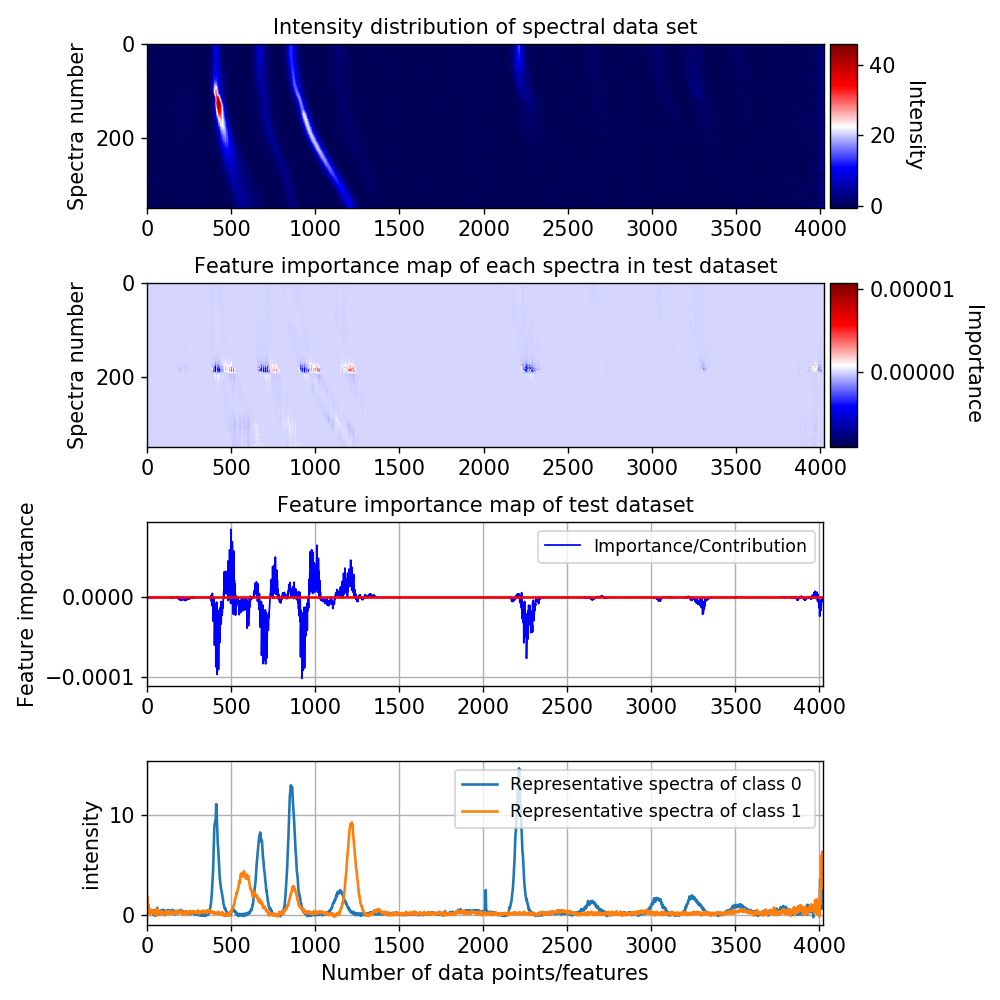

(349, 4023) (349, 4023)
-9.02913e-06 1.0693875e-05
(349, 4023) (349, 4023)
-0.5847974 45.906643


In [72]:
# start with a square Figure
fig = plt.figure(figsize=(8, 8))

# Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(4, 2,  width_ratios=(20, 1),wspace=0.00,)
#                       left=0.1, right=0.9, bottom=0.1, top=0.9,
#                       wspace=0.05, hspace=0.05

ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :])
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[3, 0])


# make these smaller to increase the resolution
dx, dy = 1, 1
# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(0, X2t.shape[0], dy),
                slice(0, X2t.shape[1], dx)]
z = dydx.view(-1,X2t.shape[1]).cpu().detach().numpy()
print(y.shape,z.shape)
z_min, z_max = z.min(), z.max()
print(z_min,z_max)
padvalue = 0.05
# fig, axs = plt.subplots(4,figsize=(8,8)) # , gridspec_kw={'height_ratios': [1, 1,1]}



ax = ax1
from mpl_toolkits.axes_grid1 import make_axes_locatable
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=padvalue) #pad=0.05
ax.tick_params(labelsize=12)
c = ax.pcolormesh(x, y, z,  cmap=plt.cm.seismic, vmin=z_min, vmax=z_max)  #seismic
ax.set_ylabel('Spectra number',fontsize=12)
# ax.set_ylim(0, 350)
ax.set_title('Feature importance map of each spectra in test dataset',fontsize=12)
cbar = fig.colorbar(c, cax=cax) #,aspect=20, cax=cax,, ,ax=ax
cbar.ax.set_ylabel('Importance', rotation=-90, va="bottom",fontsize=12)
cbar.ax.tick_params(labelsize=12)
# cbar.ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.1e'))
fig.tight_layout()
# plt.gca().invert_yaxis()
ax.invert_yaxis()
# plt.savefig(save_figures_to+"Visualization of feature importance contribution in the test dataset.png", bbox_inches='tight', dpi=300)



ax = ax0
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=padvalue)
ax.tick_params(labelsize=12)
z = X2t.cpu().detach().numpy()
print(y.shape,z.shape)
z_min, z_max = z.min(), z.max()
print(z_min,z_max)
c = ax.pcolormesh(x, y, z,  cmap=plt.cm.seismic, vmin=z_min, vmax=z_max)
ax.set_title('Intensity distribution of spectral data set',fontsize=12)
ax.set_ylabel('Spectra number',fontsize=12)
cbar = fig.colorbar(c, cax=cax) #,aspect=20, cax=cax,, ,ax=ax
cbar.ax.set_ylabel('Intensity', rotation=-90, va="bottom",fontsize=12)
cbar.ax.tick_params(labelsize=12)
ax.invert_yaxis()




ax = ax3
ax.plot(X2t[0].cpu().detach().numpy().T,label='Representative spectra of class 0 ')
ax.plot(X2t[-1].cpu().detach().numpy().T, label='Representative spectra of class 1 ')
ax.set_ylabel("intensity",fontsize=12)
ax.set_xlabel('Number of data points/features',fontsize=12)
ax.set_xlim([0,4023])
ax.tick_params(labelsize=12)
ax.legend()
ax.grid()




ax = ax2
ax.plot(f_impt.cpu().numpy(),'b',linewidth=1,label='Importance/Contribution')
ax.set_ylabel("Feature importance",fontsize=12)
ax.set_title('Feature importance map of test dataset',fontsize=12)
ax.axhline(y=0, color='r', linestyle='-')
ax.set_xlim([0,4023])
ax.tick_params(labelsize=12)
ax.legend()
ax.grid()



fig.tight_layout()
plt.savefig(save_figures_to+"Sum of gradient-based feature importance contribution in the test dataset.png", bbox_inches='tight', dpi=300)
plt.show()
